# Collaborative filtering

## Data loading

In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
print(os.environ.get("OPENBLAS_NUM_THREADS"))

1


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
RANDOM_STATE = 5482

We only take into account users that have listened more than 5 songs

In [3]:
#df_users = pd.read_csv('data/train_triplets.txt', sep='\t', header=None, names=['user_id', 'song_id', 'play_count'])
#df_users_raw = pd.read_csv('data/Million Song Dataset kaggle/User Listening History.csv')
df_users = pd.read_csv('data/User Listening History_modified.csv')

In [4]:
df_music = pd.read_csv('data/Million Song Dataset kaggle/Music Info.csv')

In [5]:
df_users.shape

(8332242, 3)

In [6]:
num_distinct_users = df_users['user_id'].nunique()
num_distinct_users

464573

In [7]:
df_music_info = df_music[['track_id', 'name', 'artist', 'energy']]
df_music_info.head()

,track_id,name,artist,energy
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,0.918
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,0.892
2,TROUVHL128F426C441,Come as You Are,Nirvana,0.826
3,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,0.664
4,TRLNZBD128F935E4D8,Creep,Radiohead,0.430


In [8]:
num_distinct_users = df_users['user_id'].nunique()
num_distinct_users

464573

## Interaction Matrix

In [9]:
df_users_agg = df_users.groupby('user_id')['playcount'].agg(
    #total_playcount='sum',
    max_playcount='max'
).reset_index()
df_users_agg = df_users_agg.rename(columns={'playcount': 'max_playcount'})

In [10]:
df_users_rating = df_users.merge(df_users_agg, on='user_id')

In [11]:
from scipy.sparse import csr_matrix

We codify each user and song to a unique integer ID

In [12]:
user_codes, user_uniques = pd.factorize(df_users['user_id'])
track_codes, track_uniques = pd.factorize(df_users['track_id'])

In [ ]:
# np.save('data/user_codes.npy', user_codes)
# np.save('data/track_codes.npy', track_codes)

# pd.Series(user_uniques).to_csv('data/user_uniques.csv', index=False)
# pd.Series(track_uniques).to_csv('data/track_uniques.csv', index=False)

## Matrix Factorization: Alternating Least Squares (ALS)

Alternating Least Squares performs very well for sparse and implicit data. So we shall calculate the interaction matrix as the playcount or as proposed in the original ALS paper:

$$
\text{confidence}_{ui} = 1 + \alpha \cdot r_{ui}
$$

We also calculate it with a bm25 weighting scheme to reduce the effect of a single user listening too many times to the same song and to direct somo of the confidence score to the most popular items, as proposed on the Implicit library documentation


In [13]:
interaction_matrix_user_item_original = csr_matrix(
    (df_users_rating['playcount'], (user_codes, track_codes)),
    shape=(len(user_uniques), len(track_uniques))
)


In [14]:
from implicit.nearest_neighbours import bm25_weight

interaction_matrix_user_item_bm25 = bm25_weight(interaction_matrix_user_item_original, K1=1.2, B=0.75).tocsr() #We use K1 and B as popular State of the Art (K1=1.2, B=0.75)


c:\Users\danih\anaconda3\envs\MasterIA\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
from implicit.als import AlternatingLeastSquares

In [16]:
class ALSRecommender:
    def __init__(self, interaction_matrix, track_uniques, df_music_info, als_model=None):
        self.interaction_matrix = interaction_matrix
        self.track_uniques = track_uniques
        self.df_music_info = df_music_info

        if als_model is None:
            self.als_model = AlternatingLeastSquares(factors=100, regularization=0.1, iterations=20, num_threads=-1, random_state=RANDOM_STATE)
            self.als_model.fit(self.interaction_matrix)
        else:
            self.als_model = als_model

        self.user_index = None
        self.recommendations = None # List of tuples (track_id, energy, similarity, has been recommended)

    def make_recommendations(self, user_index, n=100):
        self.user_index = user_index

        user_items = self.interaction_matrix.tocsr()[user_index]


        top_n_recommendations_indexes, top_n_recommendations_scores = self.als_model.recommend(user_index, user_items, N=n, filter_already_liked_items=True)

        # for i in range(len(top_n_recommendations_indexes)):
        #     print(f"Track ID: {self.track_uniques[top_n_recommendations_indexes[i]]}, Similarity: {top_n_recommendations_scores[i]}")


        track_ids = self.track_uniques[top_n_recommendations_indexes].tolist()
        
        df_filtered = self.df_music_info.set_index('track_id').loc[track_ids][['energy']].reset_index()

        self.recommendations = [(track_id, energy, similarity, False) for (track_id, energy), similarity in zip(df_filtered.itertuples(index=False, name=None), top_n_recommendations_scores)]
        return self.recommendations

    
    def recommend_song(self, energy, energy_margin=0.05):
        if self.recommendations is None:
            raise ValueError("No recommendations available. Please call make_recommendations first.")
        
        closest_track_index = None
        distance_to_energy = float('inf')

        for i, (track_id, track_energy, similarity, has_been_recommended) in enumerate(self.recommendations):
            distance = abs(track_energy - energy)

            if not has_been_recommended and distance <= energy_margin:
                self.recommendations[i] = (track_id, track_energy, similarity, True)
                return (track_id, track_energy)
            
            if not has_been_recommended and distance < distance_to_energy:
                closest_track_index = i
                distance_to_energy = distance
        
        if closest_track_index is not None:
            track_id, track_energy, _, _= self.recommendations[closest_track_index]
            self.recommendations[closest_track_index] = (track_id, track_energy, similarity, True)
            return (track_id, track_energy)

        raise ValueError("All recommendations have already been recommended")


    def get_recommendations(self):
        if self.recommendations is None:
            raise ValueError("No recommendations available. Please call make_recommendations first.")
        return self.recommendations


    def get_recommendations_ids(self):
        if self.recommendations is None:
            raise ValueError("No recommendations available. Please call make_recommendations first.")
        return [track_id for track_id, _, _, _ in self.recommendations]
    
    def get_recommendations_info(self):
        track_ids = [track_id for track_id, _, _, _ in self.recommendations]
        df_ordered = self.df_music_info.set_index('track_id').loc[track_ids].reset_index()
        return df_ordered

## Example

In [25]:
user_index = 0 #User for wich recommendations will be made
user_listened_songs = df_users[df_users['user_id'] == user_uniques[user_index]].track_id
df_music_info[df_music_info['track_id'].isin(user_listened_songs)]

,track_id,name,artist,energy
79,TRAAHSY128F147BB5C,Speed of Sound,Coldplay,0.8980
796,TRDLMWP128F426BF6C,Ragged Wood,Fleet Foxes,0.6850
1158,TRPUGUW128F426BF6F,He Doesn't Know Why,Fleet Foxes,0.5580
1743,TRRYCBO128F932A2C7,Love Shack,The B-52's,0.9020
2350,TRFUPBA128F934F7E1,Paper Gangsta,Lady Gaga,0.5300
2585,TRVODUZ128F934D094,All That We Perceive,Thievery Corporation,0.8340
2722,TRHDDQG12903CB53EE,Heaven's Gonna Burn Your Eyes,Thievery Corporation,0.3370
5416,TRTUCUY128F92E1D24,Stacked Actors,Foo Fighters,0.9340
5428,TRLXSNR128F429361D,Generator,Foo Fighters,0.9240
5819,TRADVZX128F426BF79,Sun Giant,Fleet Foxes,0.0626


In [ ]:
als_model_original = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=20, num_threads=-1, random_state=RANDOM_STATE)
als_model_original.fit(interaction_matrix_user_item_original)

100%|██████████| 20/20 [00:31<00:00,  1.56s/it]


In [ ]:
als_recommender = ALSRecommender(interaction_matrix_user_item_original, track_uniques, df_music_info, als_model=als_model_original)
als_recommender.make_recommendations(0, n=20)
als_recommender.get_recommendations_info()

,track_id,name,artist,energy
0,TRXWAZC128F9314B3E,Heartbreak Warfare,John Mayer,0.5720
1,TRONYHY128F92C9D11,Revelry,Kings of Leon,0.7480
2,TRPFYYL128F92F7144,Float On,Modest Mouse,0.8930
3,TRRXGAK128EF349F1A,The Way I Are,Timbaland,0.9460
4,TRFTUIW128E0784B9F,Bubble Toes,Jack Johnson,0.5320
5,TRAEUIW12903D018F0,You And Your Heart,Jack Johnson,0.5520
6,TROWQGL128E0784BAA,Taylor,Jack Johnson,0.7250
7,TRZNAHL128F9327D5A,Gears,Miss May I,0.9750
8,TRWAUCC128F428E6FD,Staple It Together,Jack Johnson,0.7940
9,TRCQYJE128E078FA49,The News,Jack Johnson,0.0818


In [27]:
recommended_song = als_recommender.recommend_song(0.4)
df_music_info[df_music_info['track_id'] == recommended_song[0]]

,track_id,name,artist,energy
16769,TREQOIZ128F42BCE96,I'm Gonna Find Another You,John Mayer,0.342


In [28]:
als_model_bm25 = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=20, num_threads=-1, random_state=RANDOM_STATE)
als_model_bm25.fit(interaction_matrix_user_item_bm25)

100%|██████████| 20/20 [00:31<00:00,  1.56s/it]


In [29]:
als_recommender_bm25 = ALSRecommender(interaction_matrix_user_item_bm25, track_uniques, df_music_info, als_model=als_model_bm25)
als_recommender_bm25.make_recommendations(0, n=20)
als_recommender_bm25.get_recommendations_info()

,track_id,name,artist,energy
0,TRCQYJE128E078FA49,The News,Jack Johnson,0.0818
1,TRFTUIW128E0784B9F,Bubble Toes,Jack Johnson,0.5320
2,TRWAUCC128F428E6FD,Staple It Together,Jack Johnson,0.7940
3,TRAEUIW12903D018F0,You And Your Heart,Jack Johnson,0.5520
4,TRJQRAP128F9314B3F,All We Ever Do Is Say Goodbye,John Mayer,0.5100
5,TRXWAZC128F9314B3E,Heartbreak Warfare,John Mayer,0.5720
6,TREQOIZ128F42BCE96,I'm Gonna Find Another You,John Mayer,0.3420
7,TROWQGL128E0784BAA,Taylor,Jack Johnson,0.7250
8,TRJZRTR128F9314B42,Perfectly Lonely,John Mayer,0.5300
9,TRXDINI128F146B94D,Rosemary,Deftones,0.6130


In [30]:
recommended_song = als_recommender_bm25.recommend_song(0.4)
df_music_info[df_music_info['track_id'] == recommended_song[0]]

,track_id,name,artist,energy
16769,TREQOIZ128F42BCE96,I'm Gonna Find Another You,John Mayer,0.342


## Experiments

### Confidence value proposed in article vs bm25

In [17]:
als_model_original = AlternatingLeastSquares(factors=100, regularization=0.01, iterations=20, num_threads=1, random_state=RANDOM_STATE)
als_model_original.fit(interaction_matrix_user_item_original)

100%|██████████| 20/20 [02:02<00:00,  6.13s/it]


In [18]:
als_model_bm25 = AlternatingLeastSquares(factors=100, regularization=0.01, iterations=20, num_threads=1, random_state=RANDOM_STATE)
als_model_bm25.fit(interaction_matrix_user_item_bm25)

100%|██████████| 20/20 [02:07<00:00,  6.39s/it]


In [19]:
random_generator = np.random.default_rng(seed=RANDOM_STATE)
random_users = random_generator.choice(np.arange(len(user_uniques)), size=20, replace=False)

first_different_recommendation = []

for rand_user in random_users:
    als_recommender = ALSRecommender(interaction_matrix_user_item_original, track_uniques, df_music_info, als_model=als_model_original)
    als_recommender.make_recommendations(rand_user, n=200)
    original_recommendations = als_recommender.get_recommendations_ids()

    als_recommender = ALSRecommender(interaction_matrix_user_item_bm25, track_uniques, df_music_info, als_model=als_model_bm25)
    als_recommender.make_recommendations(rand_user, n=200)
    bm25_recommendations = als_recommender.get_recommendations_ids()

    for i in range(len(original_recommendations)):
        if original_recommendations[i] != bm25_recommendations[i]:
            first_different_recommendation.append(i)
            break
    else:
        first_different_recommendation.append(-1)

print("First different recommendation for each user: (-1 = every recommendation is the same)")
print(first_different_recommendation)

First different recommendation for each user: (-1 = every recommendation is the same)
[0, 1, 2, 0, 6, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 2, 1, 2, 0, 0]


In [20]:
analized_user = random_users[0]

als_recommender = ALSRecommender(interaction_matrix_user_item_original, track_uniques, df_music_info, als_model=als_model_original)
als_recommender.make_recommendations(analized_user, n=200)
original_recommendations = als_recommender.get_recommendations_info()

als_recommender = ALSRecommender(interaction_matrix_user_item_bm25, track_uniques, df_music_info, als_model=als_model_bm25)
als_recommender.make_recommendations(analized_user, n=200)
bm25_recommendations = als_recommender.get_recommendations_info()

In [21]:
original_recommendations.head(20)

,track_id,name,artist,energy
0,TRVSJOM12903CD2DC1,One Less Lonely Girl,Justin Bieber,0.750
1,TRDGUPO128F9332CF6,Down To Earth,Bungle,0.904
2,TRCKWGF12903CD2DCD,Never Let You Go,Third Eye Blind,0.940
3,TRYEGSH12903CD2DCE,Overboard,Justin Bieber,0.790
4,TRLVQME128F931BAF3,Vanilla Twilight,Owl City,0.523
5,TRZEDRT12903CD2DCC,Runaway Love,Justin Bieber,0.633
6,TRTKLFX12903CD2DC2,First Dance,Justin Bieber,0.520
7,TRJZRTR128F9314B42,Perfectly Lonely,John Mayer,0.530
8,TROMKCG128F9320C09,Uprising,Sabaton,0.866
9,TRZYAGJ128F9332CEF,Favorite Girl,Justin Bieber,0.681


In [22]:
bm25_recommendations.head(20)

,track_id,name,artist,energy
0,TRLVQME128F931BAF3,Vanilla Twilight,Owl City,0.523
1,TRVSJOM12903CD2DC1,One Less Lonely Girl,Justin Bieber,0.750
2,TRCKWGF12903CD2DCD,Never Let You Go,Third Eye Blind,0.940
3,TRDGUPO128F9332CF6,Down To Earth,Bungle,0.904
4,TRJZRTR128F9314B42,Perfectly Lonely,John Mayer,0.530
5,TRYEGSH12903CD2DCE,Overboard,Justin Bieber,0.790
6,TRTKLFX12903CD2DC2,First Dance,Justin Bieber,0.520
7,TRZEDRT12903CD2DCC,Runaway Love,Justin Bieber,0.633
8,TRZYAGJ128F9332CEF,Favorite Girl,Justin Bieber,0.681
9,TRNFVQI128F931BAEA,The Saltwater Room,Owl City,0.686


In [23]:
original_ids = set(original_recommendations['track_id'].head(50))
bm25_ids = set(bm25_recommendations['track_id'].head(50))
porcentaje = len(original_ids & bm25_ids) / len(original_ids) * 100
print(f"Percentage of original recommendations that are in bm25 recomendations: {porcentaje:.2f}%")

Percentage of original recommendations that are in bm25 recomendations: 78.00%


In [24]:
percentage_overlap_20 = []
percentage_overlap_50 = []
percentage_overlap_200 = []

for rand_user in random_users:
    als_recommender = ALSRecommender(interaction_matrix_user_item_original, track_uniques, df_music_info, als_model=als_model_original)
    als_recommender.make_recommendations(rand_user, n=200)
    original_recommendations = als_recommender.get_recommendations_info()

    als_recommender = ALSRecommender(interaction_matrix_user_item_bm25, track_uniques, df_music_info, als_model=als_model_bm25)
    als_recommender.make_recommendations(rand_user, n=200)
    bm25_recommendations = als_recommender.get_recommendations_info()

    original_ids_20 = set(original_recommendations['track_id'].head(20))
    bm25_ids_20 = set(bm25_recommendations['track_id'].head(20))

    original_ids_50 = set(original_recommendations['track_id'].head(50))
    bm25_ids_50 = set(bm25_recommendations['track_id'].head(50))

    original_ids_200 = set(original_recommendations['track_id'])
    bm25_ids_200 = set(bm25_recommendations['track_id'])


    overlap = round(len(original_ids_20 & bm25_ids_20) / len(original_ids_20) * 100, 2)
    percentage_overlap_20.append(overlap)

    overlap = round(len(original_ids_50 & bm25_ids_50) / len(original_ids_50) * 100, 2)
    percentage_overlap_50.append(overlap)

    overlap = round(len(original_ids_200 & bm25_ids_200) / len(original_ids_200) * 100, 2)
    percentage_overlap_200.append(overlap)

print("Percentage of overlap between original and bm25 recommendations for each user:")
print(f"First 20 recommendations: {percentage_overlap_20}")
print(f"First 50 recommendations: {percentage_overlap_50}")
print(f"First 200 recommendations: {percentage_overlap_200}")

print(f"Average percentage of overlap for 20 first recommendations: {np.mean(percentage_overlap_20):.2f}%")
print(f"Median percentage of overlap for 20 first recommendations: {np.median(percentage_overlap_20):.2f}%")

print(f"Average percentage of overlap for 50 first recommendations: {np.mean(percentage_overlap_50):.2f}%")
print(f"Median percentage of overlap for 50 first recommendations: {np.median(percentage_overlap_50):.2f}%")

print(f"Average percentage of overlap for 200 first recommendations: {np.mean(percentage_overlap_200):.2f}%")
print(f"Median percentage of overlap for 200 first recommendations: {np.median(percentage_overlap_200):.2f}%")

Percentage of overlap between original and bm25 recommendations for each user:
First 20 recommendations: [80.0, 60.0, 80.0, 55.0, 55.0, 85.0, 65.0, 60.0, 35.0, 45.0, 65.0, 70.0, 60.0, 75.0, 60.0, 70.0, 50.0, 90.0, 65.0, 75.0]
First 50 recommendations: [78.0, 56.0, 78.0, 70.0, 52.0, 90.0, 72.0, 76.0, 68.0, 30.0, 64.0, 60.0, 74.0, 56.0, 64.0, 82.0, 42.0, 68.0, 68.0, 64.0]
First 200 recommendations: [50.5, 50.5, 64.5, 64.0, 47.5, 66.0, 73.0, 62.5, 47.5, 46.0, 53.0, 47.0, 65.5, 47.5, 54.0, 80.0, 61.5, 38.5, 61.0, 58.5]
Average percentage of overlap for 20 first recommendations: 65.00%
Median percentage of overlap for 20 first recommendations: 65.00%
Average percentage of overlap for 50 first recommendations: 65.60%
Median percentage of overlap for 50 first recommendations: 68.00%
Average percentage of overlap for 200 first recommendations: 56.92%
Median percentage of overlap for 200 first recommendations: 56.25%


In [25]:
from implicit.evaluation import leave_k_out_split, mean_average_precision_at_k, ndcg_at_k
from scipy.sparse import lil_matrix
from tqdm import tqdm

In [24]:
def build_split_from_indices(matrix, test_users, test_items):
    train_lil = matrix.tolil()
    test_lil = lil_matrix(matrix.shape)

   
    for u, i in zip(test_users, test_items):
        val = matrix[u, i]
        train_lil[u, i] = 0
        test_lil[u, i] = val

    
    train = train_lil.tocsr()
    test = test_lil.tocsr()
    return train, test

def generate_2_splits(interaction_matrix_1, interaction_matrix_2, k=1, random_state=RANDOM_STATE):
    train_matrix_1, test_matrix_1 = leave_k_out_split(interaction_matrix_1, K = k, random_state=random_state)
    test_users, test_items = test_matrix_1.nonzero()
    train_matrix_2, test_matrix_2 = build_split_from_indices(interaction_matrix_2, test_users, test_items)
    return train_matrix_1, test_matrix_1, train_matrix_2, test_matrix_2

In [27]:
train_matrix_original, test_matrix_original, train_matrix_bm25, test_matrix_bm25 = generate_2_splits(interaction_matrix_user_item_original, interaction_matrix_user_item_bm25, k=1)

In [28]:
als_model_original = AlternatingLeastSquares(factors=100, regularization=0.01, iterations=20, num_threads=1, random_state=RANDOM_STATE)
als_model_original.fit(train_matrix_original)
mapk_original = mean_average_precision_at_k(als_model_original, train_matrix_original, test_matrix_original, K=20, num_threads=1)
ndcg_original = ndcg_at_k(als_model_original, train_matrix_original, test_matrix_original, K=20, num_threads=1)


als_model_bm25 = AlternatingLeastSquares(factors=100, regularization=0.01, iterations=20, num_threads=1, random_state=RANDOM_STATE)
als_model_bm25.fit(train_matrix_bm25)
mapk_bm25 = mean_average_precision_at_k(als_model_bm25, train_matrix_bm25, test_matrix_bm25, K=20, num_threads=1)
ndcg_bm25 = ndcg_at_k(als_model_bm25, train_matrix_bm25, test_matrix_bm25, K=20, num_threads=1)

100%|██████████| 464573/464573 [01:29<00:00, 5175.50it/s]


In [29]:
print(f"MAP@20 for original confidences: {mapk_original:.4f}")
print(f"NDCG@20 for original confidences: {ndcg_original:.4f}")
print(f"MAP@20 for BM25 confidences: {mapk_bm25:.4f}")
print(f"NDCG@20 for BM25 confidences: {ndcg_bm25:.4f}")

MAP@20 for original confidences: 0.0943
NDCG@20 for original confidences: 0.1268
MAP@20 for BM25 confidences: 0.1162
NDCG@20 for BM25 confidences: 0.1561


In [30]:
random_states_list = [5873, 429, 9842, 7130, 1059, 886, 3247, 9011, 1678, 352]
original_mapks = []
original_ndcgs = []
bm25_mapks = []
bm25_ndcgs = []
print("Evaluation of original and BM25 confidence matrices with 5 different train/test splits:")
for i in tqdm(range(10)):
    train_original, test_original, train_bm25, test_bm25 = generate_2_splits(interaction_matrix_user_item_original, interaction_matrix_user_item_bm25, k=1, random_state=random_states_list[i])
    als_model_original = AlternatingLeastSquares(factors=100, regularization=0.01, iterations=20, num_threads=1, random_state=random_states_list[i])
    als_model_original.fit(train_original, show_progress=False)
    mapk_original = mean_average_precision_at_k(als_model_original, train_original, test_original, K=20, num_threads=1, show_progress=False)
    ndcg_original = ndcg_at_k(als_model_original, train_original, test_original, K=20, num_threads=1, show_progress=False)
    original_mapks.append(mapk_original)
    original_ndcgs.append(ndcg_original)

    als_model_bm25 = AlternatingLeastSquares(factors=100, regularization=0.01, iterations=20, num_threads=1, random_state=random_states_list[i])
    als_model_bm25.fit(train_bm25, show_progress=False)
    mapk_bm25 = mean_average_precision_at_k(als_model_bm25, train_bm25, test_bm25, K=20, num_threads=1, show_progress=False)
    ndcg_bm25 = ndcg_at_k(als_model_bm25, train_bm25, test_bm25, K=20, num_threads=1, show_progress=False)
    bm25_mapks.append(mapk_bm25)
    bm25_ndcgs.append(ndcg_bm25)

print("Evaluation completed.")

Evaluation of original and BM25 confidence matrices with 5 different train/test splits:


100%|██████████| 10/10 [1:36:57<00:00, 581.73s/it]

Evaluation completed.


In [31]:
print("MAP@20 for original confidences:")
print(original_mapks)
print("NDCG@20 for original confidences:")
print(original_ndcgs)
print("MAP@20 for BM25 confidences:")
print(bm25_mapks)
print("NDCG@20 for BM25 confidences:")
print(bm25_ndcgs)

MAP@20 for original confidences:
[0.09416072973556619, 0.0946560211625815, 0.09466550382692032, 0.09432548304197567, 0.09436906154888985, 0.09434686943487078, 0.09400661371786383, 0.0942516597591524, 0.09530160847416023, 0.09417098899049609]
NDCG@20 for original confidences:
[0.1265669708039438, 0.12713364374258626, 0.12707811826540055, 0.1267134300475855, 0.126694182393227, 0.12658976430999921, 0.12638684253211235, 0.12657872091159317, 0.12785582518219224, 0.12664586012210982]
MAP@20 for BM25 confidences:
[0.11590270029290696, 0.11685903161343969, 0.11668501821756917, 0.1167894635214904, 0.11596417939587786, 0.11620187330092437, 0.11554635280267285, 0.11649923500004297, 0.11713990851927789, 0.11625691548074371]
NDCG@20 for BM25 confidences:
[0.1558277839229707, 0.15673557253184392, 0.15662297341232156, 0.15655812900382557, 0.15574305912287667, 0.15591297473152863, 0.15549848792148932, 0.15626966079453902, 0.15730659714545714, 0.15620392367995378]


In [17]:
original_mapks = [0.09416072973556619, 0.0946560211625815, 0.09466550382692032, 0.09432548304197567, 0.09436906154888985, 0.09434686943487078, 0.09400661371786383, 0.0942516597591524, 0.09530160847416023, 0.09417098899049609]
original_ndcgs = [0.1265669708039438, 0.12713364374258626, 0.12707811826540055, 0.1267134300475855, 0.126694182393227, 0.12658976430999921, 0.12638684253211235, 0.12657872091159317, 0.12785582518219224, 0.12664586012210982]
bm25_mapks = [0.11590270029290696, 0.11685903161343969, 0.11668501821756917, 0.1167894635214904, 0.11596417939587786, 0.11620187330092437, 0.11554635280267285, 0.11649923500004297, 0.11713990851927789, 0.11625691548074371]
bm25_ndcgs = [0.1558277839229707, 0.15673557253184392, 0.15662297341232156, 0.15655812900382557, 0.15574305912287667, 0.15591297473152863, 0.15549848792148932, 0.15626966079453902, 0.15730659714545714, 0.15620392367995378]

In [18]:
results_df = pd.DataFrame({
    'Matrix': ['original', 'Bm25'],
    'MAP@20': [np.mean(original_mapks), np.mean(bm25_mapks)],
    'NDCG@20': [np.mean(original_ndcgs), np.mean(bm25_ndcgs)]
})

results_df

,Matrix,MAP@20,NDCG@20
0,original,0.094425,0.126824
1,Bm25,0.116384,0.156268


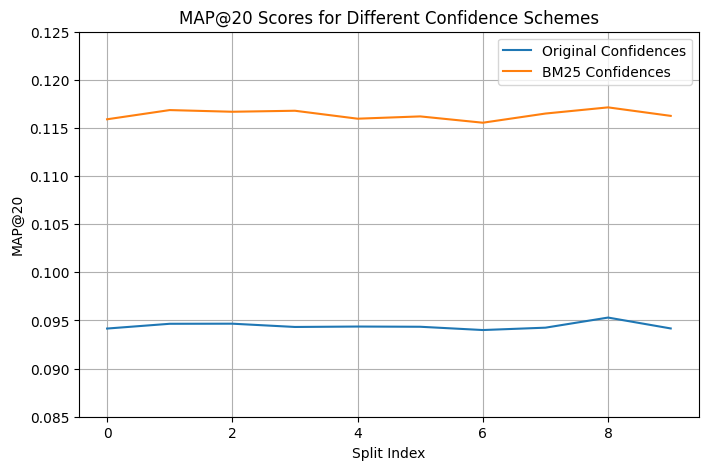

In [21]:
plt.figure(figsize=(8, 5))
plt.plot(original_mapks, label='Original Confidences')
plt.plot(bm25_mapks, label='BM25 Confidences')
plt.xlabel('Split Index')
plt.ylabel('MAP@20')
plt.title('MAP@20 Scores for Different Confidence Schemes')
plt.ylim(0.085, 0.125)
plt.legend()
plt.grid(True)
plt.show()

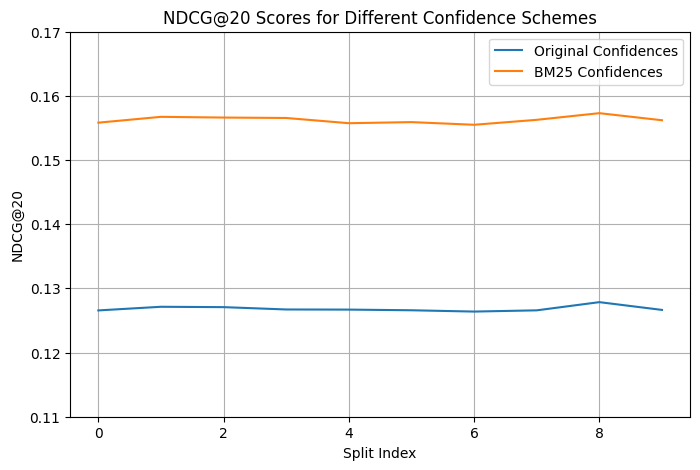

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(original_ndcgs, label='Original Confidences')
plt.plot(bm25_ndcgs, label='BM25 Confidences')
plt.xlabel('Split Index')
plt.ylabel('NDCG@20')
plt.title('NDCG@20 Scores for Different Confidence Schemes')
plt.ylim(0.11, 0.17)
plt.legend()
plt.grid(True)
plt.show()

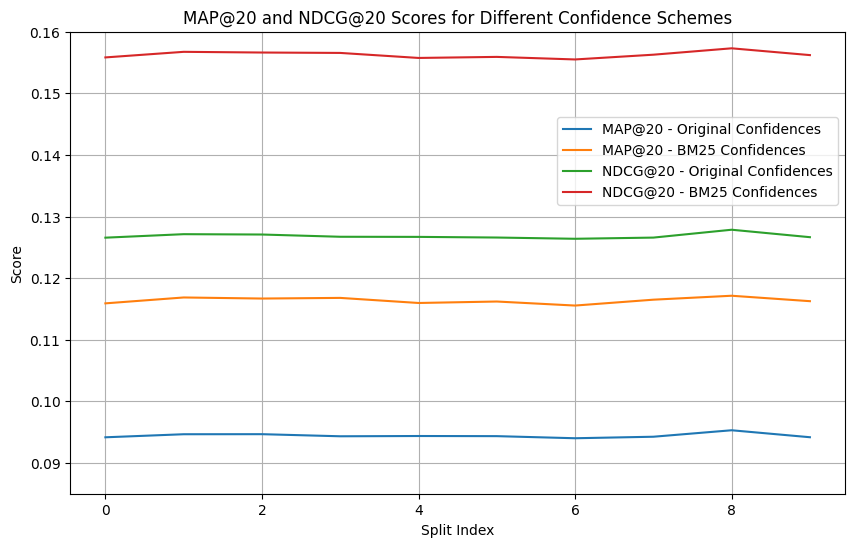

In [35]:
plt.figure(figsize=(10, 6))

plt.plot(original_mapks, label='MAP@20 - Original Confidences')
plt.plot(bm25_mapks, label='MAP@20 - BM25 Confidences')
plt.plot(original_ndcgs, label='NDCG@20 - Original Confidences')
plt.plot(bm25_ndcgs, label='NDCG@20 - BM25 Confidences')

plt.xlabel('Split Index')
plt.ylabel('Score')
plt.title('MAP@20 and NDCG@20 Scores for Different Confidence Schemes')
plt.ylim(0.085, 0.16)
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.83))
plt.grid(True)
plt.show()

### TODO-OLD de aqui para abajo eliminar

In [29]:
als_model_original = AlternatingLeastSquares(factors=100, regularization=0.01, iterations=20, num_threads=1, random_state=RANDOM_STATE)
als_model_original.fit(interaction_matrix_user_item_original)

100%|██████████| 20/20 [02:46<00:00,  8.33s/it]


In [30]:
als_model_bm25 = AlternatingLeastSquares(factors=100, regularization=0.01, iterations=20, num_threads=1, random_state=RANDOM_STATE)
als_model_bm25.fit(interaction_matrix_user_item_bm25)

100%|██████████| 20/20 [02:25<00:00,  7.29s/it]


In [36]:
random_generator = np.random.default_rng(seed=RANDOM_STATE)
random_users = random_generator.choice(np.arange(len(user_uniques)), size=20, replace=False)

first_different_recommendation = []

for rand_user in random_users:
    als_recommender = ALSRecommender(interaction_matrix_user_item_original, track_uniques, df_music_info, als_model=als_model_original)
    als_recommender.make_recommendations(rand_user, n=200)
    original_recommendations = als_recommender.get_recommendations_ids()

    als_recommender = ALSRecommender(interaction_matrix_user_item_bm25, track_uniques, df_music_info, als_model=als_model_bm25)
    als_recommender.make_recommendations(rand_user, n=200)
    bm25_recommendations = als_recommender.get_recommendations_ids()

    for i in range(len(original_recommendations)):
        if original_recommendations[i] != bm25_recommendations[i]:
            first_different_recommendation.append(i)
            break
    else:
        first_different_recommendation.append(-1)

print("First different recommendation for each user: (-1 = every recommendation is the same)")
print(first_different_recommendation)

First different recommendation for each user: (-1 = every recommendation is the same)
[0, 0, 2, 6, 2, 2, 0, 2, 1, 0, 1, 0, 1, 0, 1, 1, 1, 2, 0, 0]


In [37]:
analized_user = random_users[0]

als_recommender = ALSRecommender(interaction_matrix_user_item_original, track_uniques, df_music_info, als_model=als_model_original)
als_recommender.make_recommendations(analized_user, n=200)
original_recommendations = als_recommender.get_recommendations_info()

als_recommender = ALSRecommender(interaction_matrix_user_item_bm25, track_uniques, df_music_info, als_model=als_model_bm25)
als_recommender.make_recommendations(analized_user, n=200)
bm25_recommendations = als_recommender.get_recommendations_info()

In [39]:
original_recommendations.head(20)

,track_id,name,artist,energy
0,TRVSJOM12903CD2DC1,One Less Lonely Girl,Justin Bieber,0.750
1,TRDGUPO128F9332CF6,Down To Earth,Bungle,0.904
2,TRCKWGF12903CD2DCD,Never Let You Go,Third Eye Blind,0.940
3,TRYEGSH12903CD2DCE,Overboard,Justin Bieber,0.790
4,TRLVQME128F931BAF3,Vanilla Twilight,Owl City,0.523
5,TRZEDRT12903CD2DCC,Runaway Love,Justin Bieber,0.633
6,TRTKLFX12903CD2DC2,First Dance,Justin Bieber,0.520
7,TRJZRTR128F9314B42,Perfectly Lonely,John Mayer,0.530
8,TROMKCG128F9320C09,Uprising,Sabaton,0.866
9,TRZYAGJ128F9332CEF,Favorite Girl,Justin Bieber,0.681


In [40]:
bm25_recommendations.head(20)

,track_id,name,artist,energy
0,TRLVQME128F931BAF3,Vanilla Twilight,Owl City,0.523
1,TRVSJOM12903CD2DC1,One Less Lonely Girl,Justin Bieber,0.750
2,TRDGUPO128F9332CF6,Down To Earth,Bungle,0.904
3,TRCKWGF12903CD2DCD,Never Let You Go,Third Eye Blind,0.940
4,TRYEGSH12903CD2DCE,Overboard,Justin Bieber,0.790
5,TRTKLFX12903CD2DC2,First Dance,Justin Bieber,0.520
6,TRZEDRT12903CD2DCC,Runaway Love,Justin Bieber,0.633
7,TRJZRTR128F9314B42,Perfectly Lonely,John Mayer,0.530
8,TRZYAGJ128F9332CEF,Favorite Girl,Justin Bieber,0.681
9,TRNFVQI128F931BAEA,The Saltwater Room,Owl City,0.686


In [43]:
original_ids = set(original_recommendations['track_id'].head(50))
bm25_ids = set(bm25_recommendations['track_id'].head(50))
porcentaje = len(original_ids & bm25_ids) / len(original_ids) * 100
print(f"Percentage of original recommendations that are in bm25 recomendations: {porcentaje:.2f}%")

Percentage of paper recommendations that are in bm25 recomendations: 78.00%


In [44]:
percentage_overlap_20 = []
percentage_overlap_50 = []
percentage_overlap_200 = []

for rand_user in random_users:
    als_recommender = ALSRecommender(interaction_matrix_user_item_original, track_uniques, df_music_info, als_model=als_model_original)
    als_recommender.make_recommendations(rand_user, n=200)
    original_recommendations = als_recommender.get_recommendations_info()

    als_recommender = ALSRecommender(interaction_matrix_user_item_bm25, track_uniques, df_music_info, als_model=als_model_bm25)
    als_recommender.make_recommendations(rand_user, n=200)
    bm25_recommendations = als_recommender.get_recommendations_info()

    original_ids_20 = set(original_recommendations['track_id'].head(20))
    bm25_ids_20 = set(bm25_recommendations['track_id'].head(20))

    original_ids_50 = set(original_recommendations['track_id'].head(50))
    bm25_ids_50 = set(bm25_recommendations['track_id'].head(50))

    original_ids_200 = set(original_recommendations['track_id'])
    bm25_ids_200 = set(bm25_recommendations['track_id'])


    overlap = round(len(original_ids_20 & bm25_ids_20) / len(original_ids_20) * 100, 2)
    percentage_overlap_20.append(overlap)

    overlap = round(len(original_ids_50 & bm25_ids_50) / len(original_ids_50) * 100, 2)
    percentage_overlap_50.append(overlap)

    overlap = round(len(original_ids_200 & bm25_ids_200) / len(original_ids_200) * 100, 2)
    percentage_overlap_200.append(overlap)

print("Percentage of overlap between original and bm25 recommendations for each user:")
print(f"First 20 recommendations: {percentage_overlap_20}")
print(f"First 50 recommendations: {percentage_overlap_50}")
print(f"First 200 recommendations: {percentage_overlap_200}")

print(f"Average percentage of overlap for 20 first recommendations: {np.mean(percentage_overlap_20):.2f}%")
print(f"Median percentage of overlap for 20 first recommendations: {np.median(percentage_overlap_20):.2f}%")

print(f"Average percentage of overlap for 50 first recommendations: {np.mean(percentage_overlap_50):.2f}%")
print(f"Median percentage of overlap for 50 first recommendations: {np.median(percentage_overlap_50):.2f}%")

print(f"Average percentage of overlap for 200 first recommendations: {np.mean(percentage_overlap_200):.2f}%")
print(f"Median percentage of overlap for 200 first recommendations: {np.median(percentage_overlap_200):.2f}%")

Percentage of overlap between original and bm25 recommendations for each user:
First 20 recommendations: [70.0, 45.0, 80.0, 80.0, 40.0, 85.0, 80.0, 70.0, 35.0, 45.0, 60.0, 50.0, 45.0, 45.0, 70.0, 65.0, 65.0, 75.0, 60.0, 75.0]
First 50 recommendations: [78.0, 44.0, 80.0, 74.0, 50.0, 98.0, 80.0, 64.0, 74.0, 56.0, 52.0, 36.0, 58.0, 46.0, 70.0, 86.0, 42.0, 62.0, 58.0, 60.0]
First 200 recommendations: [47.5, 38.0, 63.5, 61.0, 45.5, 63.5, 78.5, 57.0, 54.5, 47.5, 48.5, 40.5, 61.0, 42.5, 54.5, 77.0, 52.5, 40.0, 58.0, 64.0]
Average percentage of overlap for 20 first recommendations: 62.00%
Median percentage of overlap for 20 first recommendations: 65.00%
Average percentage of overlap for 50 first recommendations: 63.40%
Median percentage of overlap for 50 first recommendations: 61.00%
Average percentage of overlap for 200 first recommendations: 54.75%
Median percentage of overlap for 200 first recommendations: 54.50%


In [26]:
from implicit.evaluation import leave_k_out_split, mean_average_precision_at_k, ndcg_at_k
from scipy.sparse import lil_matrix
from tqdm import tqdm

In [27]:
def build_split_from_indices(matrix, test_users, test_items):
    train_lil = matrix.tolil()
    test_lil = lil_matrix(matrix.shape)

   
    for u, i in zip(test_users, test_items):
        val = matrix[u, i]
        train_lil[u, i] = 0
        test_lil[u, i] = val

    
    train = train_lil.tocsr()
    test = test_lil.tocsr()
    return train, test

def generate_2_splits(interaction_matrix_1, interaction_matrix_2, k=1, random_state=RANDOM_STATE):
    train_matrix_1, test_matrix_1 = leave_k_out_split(interaction_matrix_1, K = k, random_state=random_state)
    test_users, test_items = test_matrix_1.nonzero()
    train_matrix_2, test_matrix_2 = build_split_from_indices(interaction_matrix_2, test_users, test_items)
    return train_matrix_1, test_matrix_1, train_matrix_2, test_matrix_2

In [49]:
train_matrix_original, test_matrix_original, train_matrix_bm25, test_matrix_bm25 = generate_2_splits(interaction_matrix_user_item_original, interaction_matrix_user_item_bm25, k=1)

In [50]:
als_model_original = AlternatingLeastSquares(factors=100, regularization=0.01, iterations=20, num_threads=1, random_state=RANDOM_STATE)
als_model_original.fit(train_matrix_original)
mapk_original = mean_average_precision_at_k(als_model_original, train_matrix_original, test_matrix_original, K=20, num_threads=1)
ndcg_original = ndcg_at_k(als_model_original, train_matrix_original, test_matrix_original, K=20, num_threads=1)


als_model_bm25 = AlternatingLeastSquares(factors=100, regularization=0.01, iterations=20, num_threads=1, random_state=RANDOM_STATE)
als_model_bm25.fit(train_matrix_bm25)
mapk_bm25 = mean_average_precision_at_k(als_model_bm25, train_matrix_bm25, test_matrix_bm25, K=20, num_threads=1)
ndcg_bm25 = ndcg_at_k(als_model_bm25, train_matrix_bm25, test_matrix_bm25, K=20, num_threads=1)

100%|██████████| 464573/464573 [01:48<00:00, 4280.79it/s]


In [51]:
print(f"MAP@20 for original confidences: {mapk_original:.4f}")
print(f"NDCG@20 for original confidences: {ndcg_original:.4f}")
print(f"MAP@20 for BM25 confidences: {mapk_bm25:.4f}")
print(f"NDCG@20 for BM25 confidences: {ndcg_bm25:.4f}")

MAP@20 for original confidences: 0.0947
NDCG@20 for original confidences: 0.1271
MAP@20 for BM25 confidences: 0.1098
NDCG@20 for BM25 confidences: 0.1499


In [52]:
random_states_list = [5873, 429, 9842, 7130, 1059, 886, 3247, 9011, 1678, 352]
original_mapks = []
original_ndcgs = []
bm25_mapks = []
bm25_ndcgs = []
print("Evaluation of original and BM25 confidence matrices with 5 different train/test splits:")
for i in tqdm(range(10)):
    train_original, test_original, train_bm25, test_bm25 = generate_2_splits(interaction_matrix_user_item_original, interaction_matrix_user_item_bm25, k=1, random_state=random_states_list[i])
    als_model_original = AlternatingLeastSquares(factors=100, regularization=0.01, iterations=20, num_threads=1, random_state=random_states_list[i])
    als_model_original.fit(train_original, show_progress=False)
    mapk_original = mean_average_precision_at_k(als_model_original, train_original, test_original, K=20, num_threads=1, show_progress=False)
    ndcg_original = ndcg_at_k(als_model_original, train_original, test_original, K=20, num_threads=1, show_progress=False)
    original_mapks.append(mapk_original)
    original_ndcgs.append(ndcg_original)

    als_model_bm25 = AlternatingLeastSquares(factors=100, regularization=0.01, iterations=20, num_threads=1, random_state=random_states_list[i])
    als_model_bm25.fit(train_bm25, show_progress=False)
    mapk_bm25 = mean_average_precision_at_k(als_model_bm25, train_bm25, test_bm25, K=20, num_threads=1, show_progress=False)
    ndcg_bm25 = ndcg_at_k(als_model_bm25, train_bm25, test_bm25, K=20, num_threads=1, show_progress=False)
    bm25_mapks.append(mapk_bm25)
    bm25_ndcgs.append(ndcg_bm25)

print("Evaluation completed.")

Evaluation of original and BM25 confidence matrices with 5 different train/test splits:


100%|██████████| 10/10 [2:05:08<00:00, 750.81s/it] 

Evaluation completed.


In [53]:
print("MAP@20 for original confidences:")
print(original_mapks)
print("NDCG@20 for original confidences:")
print(original_ndcgs)
print("MAP@20 for BM25 confidences:")
print(bm25_mapks)
print("NDCG@20 for BM25 confidences:")
print(bm25_ndcgs)

MAP@20 for original confidences:
[0.09468045743330353, 0.0946167937094054, 0.0943377089191461, 0.09453842600529269, 0.09461287833877081, 0.09445245929191134, 0.09352293036161632, 0.09399804456322797, 0.09471892411279671, 0.09458057115493766]
NDCG@20 for original confidences:
[0.12722236999155193, 0.12708122555890877, 0.12682280140654048, 0.1269671739064947, 0.12694226736590164, 0.12690378655853451, 0.12610246117507873, 0.12643902759345307, 0.12713996250681625, 0.12708084856104618]
MAP@20 for BM25 confidences:
[0.10950461538872582, 0.10976615432060675, 0.10934892763214522, 0.10961298200651327, 0.10934856503442462, 0.10943380443617325, 0.1088431116187444, 0.10944327128183876, 0.109672670839838, 0.10994421423991053]
NDCG@20 for BM25 confidences:
[0.14968352924303394, 0.14984389889158153, 0.149309812036694, 0.14948742072053134, 0.14924635446319276, 0.14948475830208427, 0.14891260123074834, 0.1494287949863481, 0.14959413230911472, 0.14989654675874656]


In [ ]:
results_df = pd.DataFrame({
    'Modelo': ['original', 'Bm25'],
    'MAP@20': [np.mean(original_mapks), np.mean(bm25_mapks)],
    'NDCG@20': [np.mean(original_ndcgs), np.mean(bm25_ndcgs)]
})

results_df

,Modelo,MAP@20,NDCG@20
0,original,0.094406,0.126870
1,Bm25,0.109492,0.149489


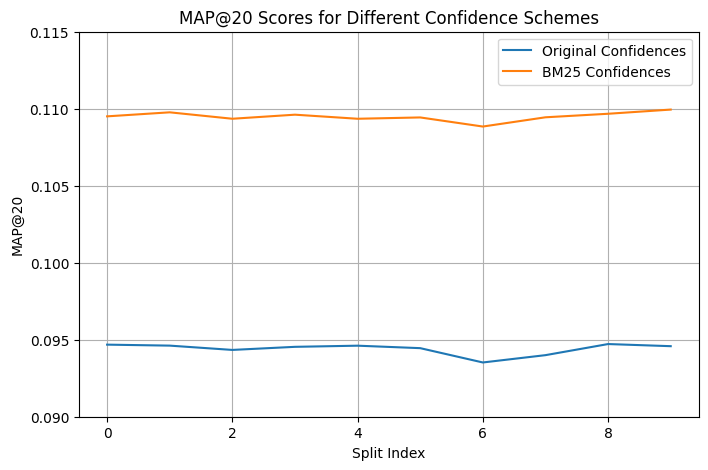

In [59]:
plt.figure(figsize=(8, 5))
plt.plot(original_mapks, label='Original Confidences')
plt.plot(bm25_mapks, label='BM25 Confidences')
plt.xlabel('Split Index')
plt.ylabel('MAP@20')
plt.title('MAP@20 Scores for Different Confidence Schemes')
plt.ylim(0.090, 0.115)
plt.legend()
plt.grid(True)
plt.show()

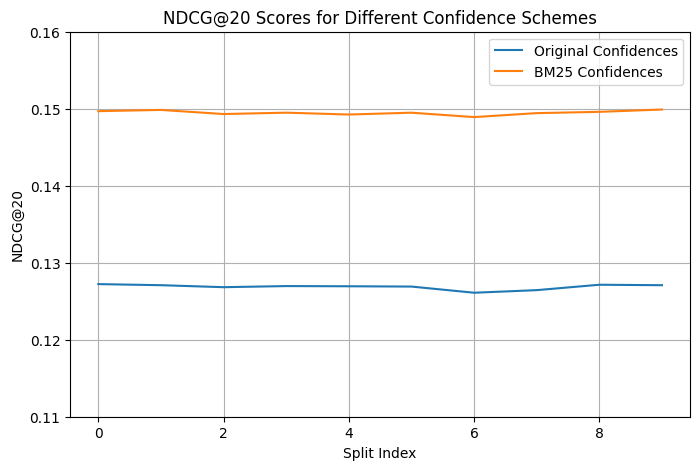

In [75]:
plt.figure(figsize=(8, 5))
plt.plot(original_ndcgs, label='Original Confidences')
plt.plot(bm25_ndcgs, label='BM25 Confidences')
plt.xlabel('Split Index')
plt.ylabel('NDCG@20')
plt.title('NDCG@20 Scores for Different Confidence Schemes')
plt.ylim(0.11, 0.16)
plt.legend()
plt.grid(True)
plt.show()

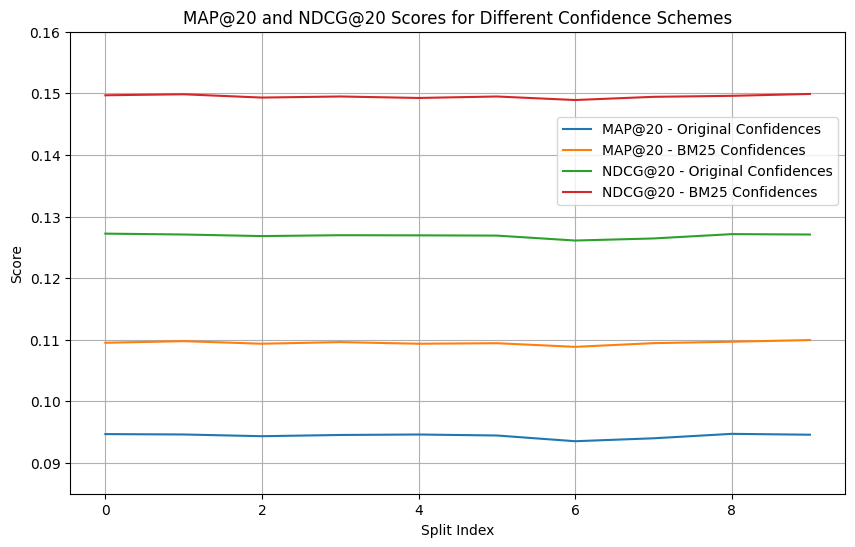

In [84]:
plt.figure(figsize=(10, 6))

plt.plot(original_mapks, label='MAP@20 - Original Confidences')
plt.plot(bm25_mapks, label='MAP@20 - BM25 Confidences')
plt.plot(original_ndcgs, label='NDCG@20 - Original Confidences')
plt.plot(bm25_ndcgs, label='NDCG@20 - BM25 Confidences')

plt.xlabel('Split Index')
plt.ylabel('Score')
plt.title('MAP@20 and NDCG@20 Scores for Different Confidence Schemes')
plt.ylim(0.085, 0.16)
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.83))
plt.grid(True)
plt.show()

The use of bm25 increases the performance of the model in every single train/test split.

## Hyperparameters

In [23]:
from implicit.evaluation import leave_k_out_split, mean_average_precision_at_k, ndcg_at_k
from sklearn.model_selection import ParameterSampler
from scipy.sparse import save_npz, load_npz

In [92]:
train_matrix_params, val_matrix_params = leave_k_out_split(interaction_matrix_user_item_bm25, K = 1, random_state=RANDOM_STATE)

In [ ]:
save_npz('matrices/train_matrix_params_random_bm25_fixed.npz', train_matrix_params)
save_npz('matrices/val_matrix_params_random_bm25_fixed.npz', val_matrix_params)

In [94]:
parameter_distribution = {
    'factors': [16, 32, 50, 64, 100, 128, 164, 200],
    'regularization': [0.001, 0.01, 0.1, 1.0],
    'alpha': [0.1, 1, 2, 5, 10, 20, 30, 40, 50, 80, 100, 200]
}

random_params = list(ParameterSampler(parameter_distribution, n_iter=40, random_state=RANDOM_STATE))

In [95]:
random_params

[{'regularization': 0.001, 'factors': 200, 'alpha': 50},
 {'regularization': 1.0, 'factors': 50, 'alpha': 10},
 {'regularization': 0.01, 'factors': 64, 'alpha': 2},
 {'regularization': 0.1, 'factors': 64, 'alpha': 20},
 {'regularization': 0.01, 'factors': 100, 'alpha': 10},
 {'regularization': 1.0, 'factors': 128, 'alpha': 200},
 {'regularization': 0.1, 'factors': 16, 'alpha': 80},
 {'regularization': 0.01, 'factors': 64, 'alpha': 5},
 {'regularization': 0.1, 'factors': 32, 'alpha': 80},
 {'regularization': 0.001, 'factors': 200, 'alpha': 200},
 {'regularization': 0.1, 'factors': 200, 'alpha': 40},
 {'regularization': 0.1, 'factors': 32, 'alpha': 30},
 {'regularization': 0.1, 'factors': 128, 'alpha': 100},
 {'regularization': 1.0, 'factors': 164, 'alpha': 50},
 {'regularization': 0.01, 'factors': 50, 'alpha': 80},
 {'regularization': 1.0, 'factors': 32, 'alpha': 50},
 {'regularization': 1.0, 'factors': 64, 'alpha': 30},
 {'regularization': 0.1, 'factors': 128, 'alpha': 1},
 {'regulariz

In [96]:
from collections import Counter
factors_counter = Counter(param['factors'] for param in random_params)
regularization_counter = Counter(param['regularization'] for param in random_params)
alpha_counter = Counter(param['alpha'] for param in random_params)

# Ordenar por clave de mayor a menor
factors_sorted = dict(sorted(factors_counter.items(), key=lambda x: x[0], reverse=False))
regularization_sorted = dict(sorted(regularization_counter.items(), key=lambda x: x[0], reverse=False))
alpha_sorted = dict(sorted(alpha_counter.items(), key=lambda x: x[0], reverse=False))

# Mostrar resultados
print("Frequencies of 'factors':", factors_sorted)
print("Frequencies of 'regularization':", regularization_sorted)
print("Frequencies of 'alpha':", alpha_sorted)

Frequencies of 'factors': {16: 2, 32: 5, 50: 3, 64: 9, 100: 4, 128: 6, 164: 2, 200: 9}
Frequencies of 'regularization': {0.001: 8, 0.01: 8, 0.1: 11, 1.0: 13}
Frequencies of 'alpha': {0.1: 2, 1: 2, 2: 3, 5: 3, 10: 4, 20: 4, 30: 2, 40: 4, 50: 5, 80: 6, 100: 3, 200: 2}


In [28]:
def study_params(train_matrix, val_matrix, params, save_results=False, save_path='als_hyperparameter_tuning_results.csv', random_state=RANDOM_STATE):
    map_scores = []
    ndcg_scores = []

    for param_comb in tqdm(params):
        als_model = AlternatingLeastSquares(
            factors=param_comb['factors'],
            regularization=param_comb['regularization'],
            alpha=param_comb['alpha'],
            iterations=20,
            num_threads=1,
            random_state=random_state
        )
        
        als_model.fit(train_matrix, show_progress=False)
        score = mean_average_precision_at_k(als_model, train_matrix, val_matrix, K=20, num_threads=1, show_progress=False)
        ndcg_score = ndcg_at_k(als_model, train_matrix, val_matrix, K=20, num_threads=1, show_progress=False)

        map_scores.append(score)
        ndcg_scores.append(ndcg_score)

        if save_results:
            result = {
                'factors': param_comb['factors'],
                'regularization': param_comb['regularization'],
                'alpha': param_comb['alpha'],
                'map_score': score,
                'ndcg_score': ndcg_score
            }
            pd.DataFrame([result]).to_csv(save_path, mode='a', header=False, index=False)

    return map_scores, ndcg_scores

#TODO: Eliminar la siguiente funcion, es solo para pruebas
def study_params_aux(train_matrix, val_matrix, params, save_results=False):
    print(f"Training ALS model with parameters: {params}")
    als_model_aux = AlternatingLeastSquares(
        factors=params['factors'],
        regularization=params['regularization'],
        alpha=params['alpha'],
        iterations=20,
        num_threads=1,
        random_state=RANDOM_STATE
    )
    
    als_model_aux.fit(train_matrix, show_progress=True)
    return als_model_aux

def get_study_results(als_model_get, train_matrix_get, val_matrix_get, params_get):
    map_score = mean_average_precision_at_k(als_model_get, train_matrix_get, val_matrix_get, K=20, num_threads=1, show_progress=True)
    ndcg_score = ndcg_at_k(als_model_get, train_matrix_get, val_matrix_get, K=20, num_threads=1, show_progress=True)
    return map_score, ndcg_score

In [98]:
map_scores, ndcg_scores = study_params(train_matrix_params, val_matrix_params, random_params, save_results=True, save_path='als_hyperparameter_tuning_results_params_random_bm25_fixed.csv')

100%|██████████| 40/40 [3:26:34<00:00, 309.86s/it]  


In [99]:
print("MAP@20 scores:")
print(map_scores)
print("NDCG@20 scores:")
print(ndcg_scores)

MAP@20 scores:
[0.1366239335216462, 0.09326704388467745, 0.10333727532728909, 0.09740398250310049, 0.11816513801485526, 0.10692810969348568, 0.0441815808590315, 0.10356194002733367, 0.057207171038943565, 0.11256886381823376, 0.14270899457635244, 0.06966670595215907, 0.11233562573491407, 0.13498594588316898, 0.07111119743838933, 0.0643374568477983, 0.09433015457747253, 0.1230261918776417, 0.1157748441182249, 0.13426190674117963, 0.1264677354704898, 0.10348035972600349, 0.10400861257422318, 0.05805324120919207, 0.14452463517092548, 0.061334438570609835, 0.10892830117873457, 0.14263090687847918, 0.1406061843375525, 0.12269906715190233, 0.10447397898418685, 0.12287623174366875, 0.09878580361049372, 0.13307849926378032, 0.08085825727745967, 0.08762491703599701, 0.0791474460563808, 0.12992767623641685, 0.0730464469410429, 0.07779022303496315]
NDCG@20 scores:
[0.18490328511630538, 0.13261022160434618, 0.14211530201073458, 0.13952450480536097, 0.16446103626349542, 0.14653173449384835, 0.067976

In [100]:
with open('hyperparams_fixed.txt', 'w') as f:
    f.write('random_params = ' + repr(random_params) + '\n')
    f.write('map_scores = ' + repr(map_scores) + '\n')
    f.write('ndcg_scores = ' + repr(ndcg_scores) + '\n')

In [101]:
best_map_idx = max(range(len(map_scores)), key=lambda i: map_scores[i])
best_ndcg_idx = max(range(len(ndcg_scores)), key=lambda i: ndcg_scores[i])

best_map_params = random_params[best_map_idx]
best_ndcg_params = random_params[best_ndcg_idx]

print(f"Best MAP: index={best_map_idx}, params={best_map_params}, MAP={map_scores[best_map_idx]}")
print(f"Best NDCG: index={best_ndcg_idx}, params={best_ndcg_params}, NDCG={ndcg_scores[best_ndcg_idx]}")


Best MAP: index=24, params={'regularization': 1.0, 'factors': 200, 'alpha': 40}, MAP=0.14452463517092548
Best NDCG: index=24, params={'regularization': 1.0, 'factors': 200, 'alpha': 40}, NDCG=0.19309881809874205


In [102]:
print("Five best MAP@20 scores and their parameters:")
for idx in sorted(range(len(map_scores)), key=lambda i: map_scores[i], reverse=True)[0:5]:
    print(f"Index: {idx}, MAP@20: {map_scores[idx]:.4f}, Params: {random_params[idx]}")

print("\nFive best NDCG@20 scores and their parameters:")
for idx in sorted(range(len(ndcg_scores)), key=lambda i: ndcg_scores[i], reverse=True)[0:5]:
    print(f"Index: {idx}, NDCG@20: {ndcg_scores[idx]:.4f}, Params: {random_params[idx]}")

Five best MAP@20 scores and their parameters:
Index: 24, MAP@20: 0.1445, Params: {'regularization': 1.0, 'factors': 200, 'alpha': 40}
Index: 10, MAP@20: 0.1427, Params: {'regularization': 0.1, 'factors': 200, 'alpha': 40}
Index: 27, MAP@20: 0.1426, Params: {'regularization': 0.001, 'factors': 200, 'alpha': 10}
Index: 28, MAP@20: 0.1406, Params: {'regularization': 1.0, 'factors': 200, 'alpha': 2}
Index: 0, MAP@20: 0.1366, Params: {'regularization': 0.001, 'factors': 200, 'alpha': 50}

Five best NDCG@20 scores and their parameters:
Index: 24, NDCG@20: 0.1931, Params: {'regularization': 1.0, 'factors': 200, 'alpha': 40}
Index: 27, NDCG@20: 0.1928, Params: {'regularization': 0.001, 'factors': 200, 'alpha': 10}
Index: 10, NDCG@20: 0.1903, Params: {'regularization': 0.1, 'factors': 200, 'alpha': 40}
Index: 28, NDCG@20: 0.1872, Params: {'regularization': 1.0, 'factors': 200, 'alpha': 2}
Index: 0, NDCG@20: 0.1849, Params: {'regularization': 0.001, 'factors': 200, 'alpha': 50}


In [103]:
results_df = pd.DataFrame(random_params)
results_df['MAP@20'] = map_scores
results_df['NDCG@20'] = ndcg_scores
results_df.to_csv('als_hyperparameter_tuning_results_random.csv', index=False)

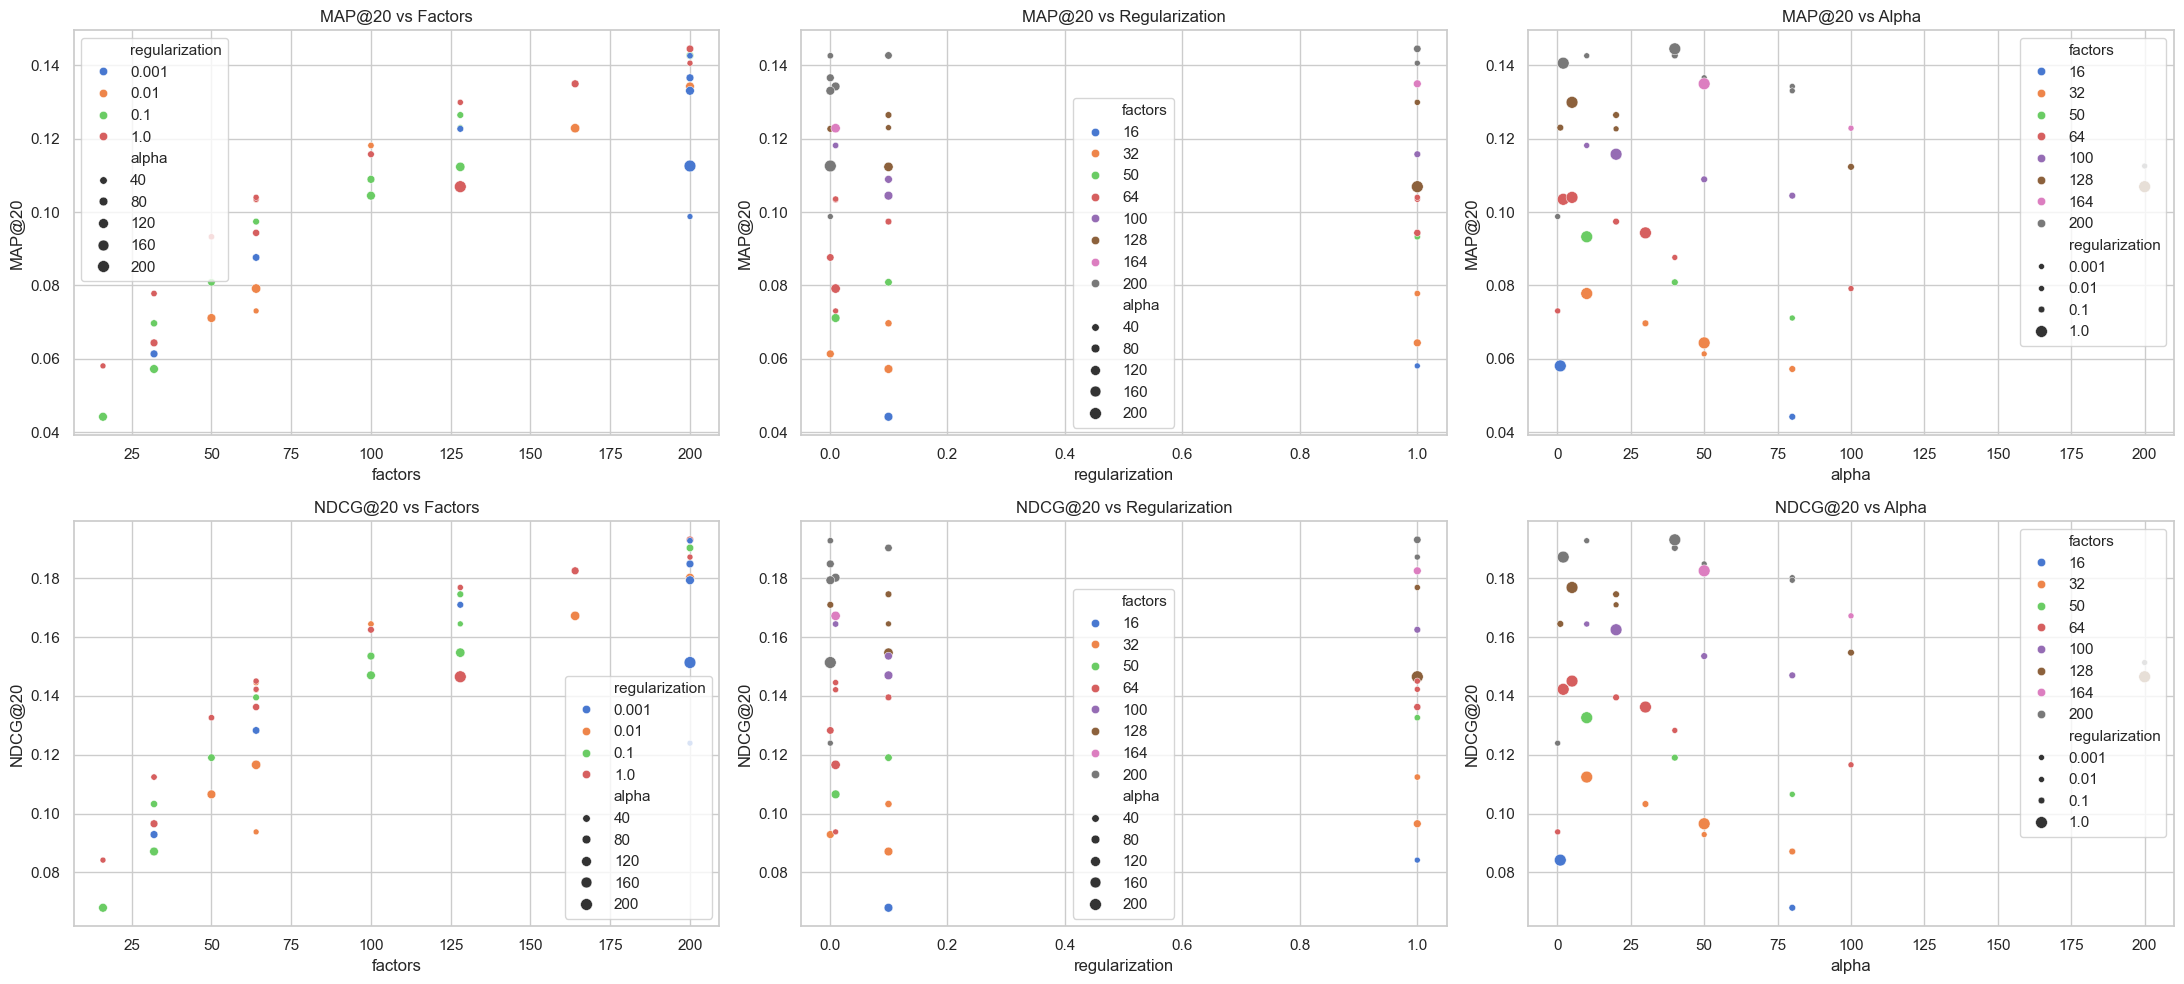

In [104]:
sns.set_theme(style="whitegrid", palette="muted")

fig, axes = plt.subplots(2, 3, figsize=(22, 10))

# Crear paletas adaptadas al número de categorías
palette_reg = sns.color_palette("muted", n_colors=results_df['regularization'].nunique())
palette_factors = sns.color_palette("muted", n_colors=results_df['factors'].nunique())

# MAP@20 plots
sns.scatterplot(data=results_df, x='factors', y='MAP@20', hue='regularization', size='alpha', ax=axes[0, 0], palette=palette_reg)
axes[0, 0].set_title('MAP@20 vs Factors')

sns.scatterplot(data=results_df, x='regularization', y='MAP@20', hue='factors', size='alpha', ax=axes[0, 1], palette=palette_factors)
axes[0, 1].set_title('MAP@20 vs Regularization')

sns.scatterplot(data=results_df, x='alpha', y='MAP@20', hue='factors', size='regularization', ax=axes[0, 2], palette=palette_factors)
axes[0, 2].set_title('MAP@20 vs Alpha')

# NDCG@20 plots
sns.scatterplot(data=results_df, x='factors', y='NDCG@20', hue='regularization', size='alpha', ax=axes[1, 0], palette=palette_reg)
axes[1, 0].set_title('NDCG@20 vs Factors')

sns.scatterplot(data=results_df, x='regularization', y='NDCG@20', hue='factors', size='alpha', ax=axes[1, 1], palette=palette_factors)
axes[1, 1].set_title('NDCG@20 vs Regularization')

sns.scatterplot(data=results_df, x='alpha', y='NDCG@20', hue='factors', size='regularization', ax=axes[1, 2], palette=palette_factors)
axes[1, 2].set_title('NDCG@20 vs Alpha')

plt.tight_layout()
plt.show()

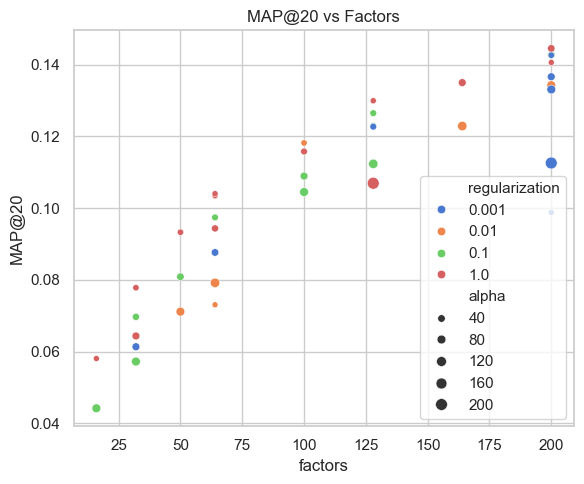

In [105]:
sns.set_theme(style="whitegrid", palette="muted")
palette_reg = sns.color_palette("muted", n_colors=results_df['regularization'].nunique())

fig, ax = plt.subplots(figsize=(6, 5))
sns.scatterplot(data=results_df, x='factors', y='MAP@20', hue='regularization', size='alpha', ax=ax, palette=palette_reg)
ax.set_title('MAP@20 vs Factors')
plt.tight_layout()
plt.show()

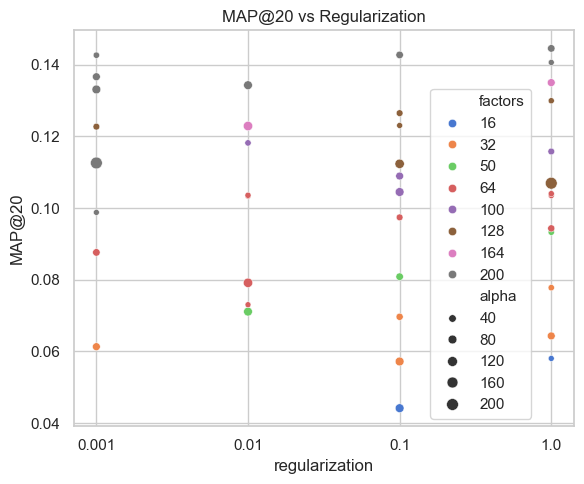

In [106]:
sns.set_theme(style="whitegrid", palette="muted")
palette_factors = sns.color_palette("muted", n_colors=results_df['factors'].nunique())

fig, ax = plt.subplots(figsize=(6, 5))
sns.scatterplot(data=results_df, x='regularization', y='MAP@20', hue='factors', size='alpha', ax=ax, palette=palette_factors)
plt.xscale('log')
plt.xticks([0.001, 0.01, 0.1, 1.0], ['0.001', '0.01', '0.1', '1.0'])
ax.set_title('MAP@20 vs Regularization')
plt.legend(loc='lower right', bbox_to_anchor=(0.93, 0), ncol=1)
plt.tight_layout()
plt.show()

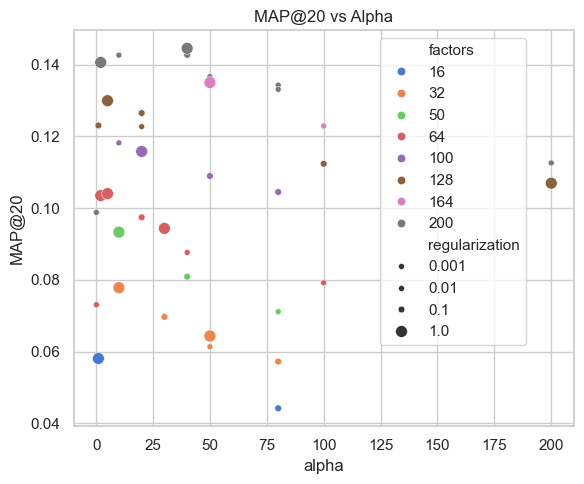

In [107]:
sns.set_theme(style="whitegrid", palette="muted")
palette_factors = sns.color_palette("muted", n_colors=results_df['factors'].nunique())

fig, ax = plt.subplots(figsize=(6, 5))
sns.scatterplot(data=results_df, x='alpha', y='MAP@20', hue='factors', size='regularization', ax=ax, palette=palette_factors)
ax.set_title('MAP@20 vs Alpha')
plt.legend(loc='upper right', bbox_to_anchor=(0.92, 1), ncol=1)
plt.tight_layout()
plt.show()

We can understand the following information:
- We see that, independently $\alpha$ and regularization values, the bigger the latent factor number, the better results.
- $\alpha$ $\in$ [1, 50] gives the best results overall.
- Regarding regularization, 1 and 0.001 have very similar results. For a value of 0.01, the results vary a lot, having the worst MAP@20 but also a maximum value near of those of 0.001 and 1. 0.01 present both the worst MAP@20 and one of the best one. This analysis does not give much information about the regularization variable. It will need to be study further later.

Knowing that the bigger the latent factor the better we will try bigger values. We will use alpha = 1 and regularization = 1, due to them giving the best results.

In [25]:
from sklearn.model_selection import ParameterGrid

factors_params = {
    'factors': [200, 300, 400, 500, 800, 900, 1000, 1500, 2000],
    'regularization': [1],
    'alpha': [40]
}

factors_combinations = list(ParameterGrid(factors_params))

In [26]:
factors_combinations

[{'alpha': 40, 'factors': 200, 'regularization': 1},
 {'alpha': 40, 'factors': 300, 'regularization': 1},
 {'alpha': 40, 'factors': 400, 'regularization': 1},
 {'alpha': 40, 'factors': 500, 'regularization': 1},
 {'alpha': 40, 'factors': 800, 'regularization': 1},
 {'alpha': 40, 'factors': 900, 'regularization': 1},
 {'alpha': 40, 'factors': 1000, 'regularization': 1},
 {'alpha': 40, 'factors': 1500, 'regularization': 1},
 {'alpha': 40, 'factors': 2000, 'regularization': 1}]

In [40]:
# train_matrix_params, val_matrix_params = leave_k_out_split(interaction_matrix_user_item_bm25, K = 1, random_state=RANDOM_STATE)

In [41]:
# save_npz('matrices/train_matrix_factors_bm25_fixed.npz', train_matrix_params)
# save_npz('matrices/val_matrix_factors_bm25_fixed.npz', val_matrix_params)

In [27]:
train_matrix_params = load_npz('matrices/train_matrix_factors_bm25_fixed.npz')
val_matrix_params = load_npz('matrices/val_matrix_factors_bm25_fixed.npz')

In [ ]:
map_scores_factor, ndcg_scores_factor = study_params(train_matrix_params, val_matrix_params, factors_combinations, save_results=True, save_path='als_hyperparameter_tuning_results_factors_bm25_fixed.csv')

 89%|████████▉ | 8/9 [4:03:08<47:18, 2838.51s/it]  

In [30]:
#load from 'als_hyperparameter_tuning_results_factors_bm25_fixed.csv'
df_results_factors = pd.read_csv('als_hyperparameter_tuning_results_factors_bm25_fixed.csv', header=None)
df_results_factors.head()

,0,1,2,3,4
0,200,1,40,0.145010,0.193486
1,300,1,40,0.160237,0.208568
2,400,1,40,0.166399,0.213162
3,500,1,40,0.167576,0.213242
4,800,1,40,0.165473,0.209606


In [34]:
map_scores_factor = df_results_factors.iloc[:, 3].tolist()
ndcg_scores_factor = df_results_factors.iloc[:, 4].tolist()

In [35]:
print("MAP@20 scores for factors 200, 300, 400, 500, 800, 900, 1000, 1500 and 2000:")
print(map_scores_factor)
print("NDCG@20 scores for factors 200, 300, 400, 500, 800, 900, 1000, 1500 and 2000:")
print(ndcg_scores_factor)

MAP@20 scores for factors 200, 300, 400, 500, 800, 900, 1000, 1500 and 2000:
[0.1450099548994192, 0.1602373085464022, 0.166399077204922, 0.1675761061137607, 0.1654728307304442, 0.163618251251415, 0.1620846461358583, 0.1525329034996818]
NDCG@20 scores for factors 200, 300, 400, 500, 800, 900, 1000, 1500 and 2000:
[0.1934861657335527, 0.2085680765215128, 0.2131622039487352, 0.2132423859034991, 0.2096061997751273, 0.2074351930095823, 0.2054424258291768, 0.1944521872970171]


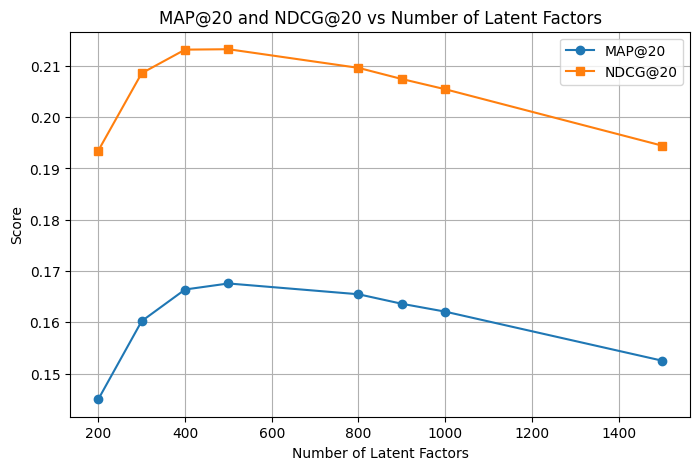

In [36]:
plt.figure(figsize=(8, 5))
plt.plot([c['factors'] for c in factors_combinations[:len(map_scores_factor)]], map_scores_factor, marker='o', label='MAP@20')
plt.plot([c['factors'] for c in factors_combinations[:len(map_scores_factor)]], ndcg_scores_factor, marker='s', label='NDCG@20')
plt.xlabel('Number of Latent Factors')
plt.ylabel('Score')
plt.title('MAP@20 and NDCG@20 vs Number of Latent Factors')
plt.legend()
plt.grid(True)
plt.show()

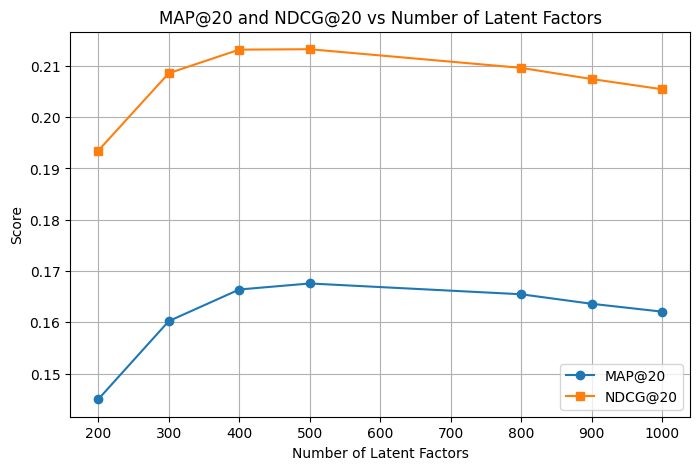

In [37]:
plt.figure(figsize=(8, 5))
plt.plot([c['factors'] for c in factors_combinations[:len(map_scores_factor) - 1]], map_scores_factor[:len(map_scores_factor) - 1], marker='o', label='MAP@20')
plt.plot([c['factors'] for c in factors_combinations[:len(map_scores_factor) - 1]], ndcg_scores_factor[:len(map_scores_factor) - 1], marker='s', label='NDCG@20')
plt.xlabel('Number of Latent Factors')
plt.ylabel('Score')
plt.title('MAP@20 and NDCG@20 vs Number of Latent Factors')
plt.legend()
plt.grid(True)
plt.show()

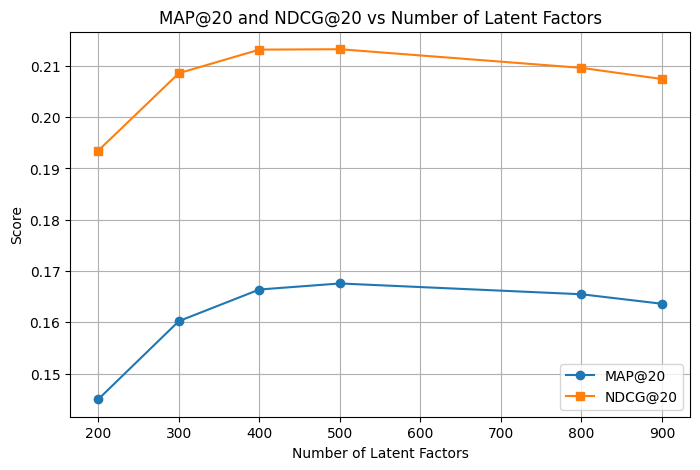

In [38]:
plt.figure(figsize=(8, 5))
plt.plot([c['factors'] for c in factors_combinations[:len(map_scores_factor) - 2]], map_scores_factor[:len(map_scores_factor) - 2], marker='o', label='MAP@20')
plt.plot([c['factors'] for c in factors_combinations[:len(map_scores_factor) - 2]], ndcg_scores_factor[:len(map_scores_factor) - 2], marker='s', label='NDCG@20')
plt.xlabel('Number of Latent Factors')
plt.ylabel('Score')
plt.title('MAP@20 and NDCG@20 vs Number of Latent Factors')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
from sklearn.model_selection import ParameterGrid

factors_params = {
    'factors': [400, 450, 500, 550, 600, 650, 700, 750, 800],
    'regularization': [1],
    'alpha': [40]
}

factors_combinations_2 = list(ParameterGrid(factors_params))

In [40]:
factors_combinations_2

[{'alpha': 40, 'factors': 400, 'regularization': 1},
 {'alpha': 40, 'factors': 450, 'regularization': 1},
 {'alpha': 40, 'factors': 500, 'regularization': 1},
 {'alpha': 40, 'factors': 550, 'regularization': 1},
 {'alpha': 40, 'factors': 600, 'regularization': 1},
 {'alpha': 40, 'factors': 650, 'regularization': 1},
 {'alpha': 40, 'factors': 700, 'regularization': 1},
 {'alpha': 40, 'factors': 750, 'regularization': 1},
 {'alpha': 40, 'factors': 800, 'regularization': 1}]

In [41]:
map_scores_factor_2, ndcg_scores_factor_2 = study_params(train_matrix_params, val_matrix_params, factors_combinations_2, save_results=True, save_path='als_hyperparameter_tuning_results_factors_bm25_fixed_2.csv')

100%|██████████| 9/9 [4:39:22<00:00, 1862.55s/it]  


In [42]:
print("MAP@20 scores for factors 400, 450, 500, 550, 600, 650, 700, 750 and 800:")
print(map_scores_factor_2)
print("NDCG@20 scores for factors 400, 450, 500, 550, 600, 650, 700, 750 and 800:")
print(ndcg_scores_factor_2)

MAP@20 scores for factors 400, 450, 500, 550, 600, 650, 700, 750 and 800:
[0.16639907720492206, 0.16753703739922565, 0.1675761061137607, 0.16777074985269277, 0.16827298691709572, 0.16727020896389383, 0.16693156377310395, 0.16616442608875584, 0.16547283073044422]
NDCG@20 scores for factors 400, 450, 500, 550, 600, 650, 700, 750 and 800:
[0.21316220394873522, 0.21367318604242477, 0.21324238590349914, 0.21311853873799663, 0.21341485735595583, 0.21213297655507815, 0.21151817820533475, 0.21066667558839405, 0.2096061997751273]


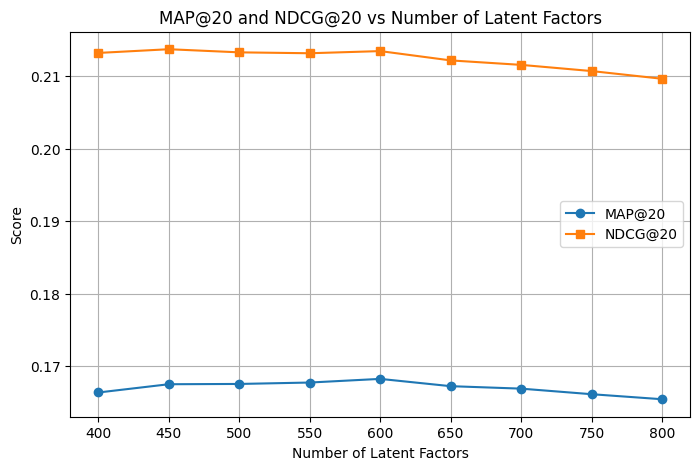

In [43]:
plt.figure(figsize=(8, 5))
plt.plot([c['factors'] for c in factors_combinations_2[:len(map_scores_factor_2)]], map_scores_factor_2, marker='o', label='MAP@20')
plt.plot([c['factors'] for c in factors_combinations_2[:len(map_scores_factor_2)]], ndcg_scores_factor_2, marker='s', label='NDCG@20')
plt.xlabel('Number of Latent Factors')
plt.ylabel('Score')
plt.title('MAP@20 and NDCG@20 vs Number of Latent Factors')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
max_idx = max(range(len(map_scores_factor_2)), key=lambda i: map_scores_factor_2[i])
print(f"Best MAP@20: {factors_combinations_2[max_idx]}, Value: {map_scores_factor_2[max_idx]}")
max_idx = max(range(len(ndcg_scores_factor_2)), key=lambda i: ndcg_scores_factor_2[i])
print(f"Best NDCG@20: {factors_combinations_2[max_idx]}, Value: {ndcg_scores_factor_2[max_idx]}")

Best MAP@20: {'alpha': 40, 'factors': 600, 'regularization': 1}, Value: 0.16827298691709572
Best NDCG@20: {'alpha': 40, 'factors': 450, 'regularization': 1}, Value: 0.21367318604242477


In [48]:
#All values ordered by MAP@20
ordered_map_scores = sorted(zip(map_scores_factor_2, factors_combinations_2), reverse=True)
print("Top 3 values ordered by MAP@20:")
for score, params in ordered_map_scores[:3]:
    print(f"MAP@20: {score}, Params: {params}")
#All values ordered by NDCG@20
ordered_ndcg_scores = sorted(zip(ndcg_scores_factor_2, factors_combinations_2), reverse=True)
print("Top 3 values ordered by NDCG@20:")
for score, params in ordered_ndcg_scores[:3]:
    print(f"NDCG@20: {score}, Params: {params}")

Top 3 values ordered by MAP@20:
MAP@20: 0.16827298691709572, Params: {'alpha': 40, 'factors': 600, 'regularization': 1}
MAP@20: 0.16777074985269277, Params: {'alpha': 40, 'factors': 550, 'regularization': 1}
MAP@20: 0.1675761061137607, Params: {'alpha': 40, 'factors': 500, 'regularization': 1}
Top 3 values ordered by NDCG@20:
NDCG@20: 0.21367318604242477, Params: {'alpha': 40, 'factors': 450, 'regularization': 1}
NDCG@20: 0.21341485735595583, Params: {'alpha': 40, 'factors': 600, 'regularization': 1}
NDCG@20: 0.21324238590349914, Params: {'alpha': 40, 'factors': 500, 'regularization': 1}


In [53]:
alpha_params = {
    'factors': [600],
    'regularization': [1.0],
    'alpha': [1, 10, 20, 30, 40, 50, 60, 80, 100, 200]
}

alpha_combinations = list(ParameterGrid(alpha_params))

In [54]:
alpha_combinations

[{'alpha': 1, 'factors': 600, 'regularization': 1.0},
 {'alpha': 10, 'factors': 600, 'regularization': 1.0},
 {'alpha': 20, 'factors': 600, 'regularization': 1.0},
 {'alpha': 30, 'factors': 600, 'regularization': 1.0},
 {'alpha': 40, 'factors': 600, 'regularization': 1.0},
 {'alpha': 50, 'factors': 600, 'regularization': 1.0},
 {'alpha': 60, 'factors': 600, 'regularization': 1.0},
 {'alpha': 80, 'factors': 600, 'regularization': 1.0},
 {'alpha': 100, 'factors': 600, 'regularization': 1.0},
 {'alpha': 200, 'factors': 600, 'regularization': 1.0}]

In [55]:
map_scores_alpha, ndcg_scores_alpha = study_params(train_matrix_params, val_matrix_params, alpha_combinations, save_results=True, save_path='als_hyperparameter_tuning_results_alpha_bm25_fixed.csv')

100%|██████████| 10/10 [4:21:51<00:00, 1571.14s/it] 


In [56]:
print("MAP@20 scores for alpha 1, 10, 20, 30, 40, 50, 60, 80, 100 and 200:")
print(map_scores_alpha)
print("NDCG@20 scores for alpha 1, 10, 20, 30, 40, 50, 60, 80, 100 and 200:")
print(ndcg_scores_alpha)

MAP@20 scores for alpha 1, 10, 20, 30, 40, 50, 60, 80, 100 and 200:
[0.16568424120091801, 0.17947931962876276, 0.17705250154869406, 0.1726919548308298, 0.16827298691709572, 0.16376916502211442, 0.15933145819007782, 0.15107178592070025, 0.14360376795104782, 0.11268374485968904]
NDCG@20 scores for alpha 1, 10, 20, 30, 40, 50, 60, 80, 100 and 200:
[0.21137375967306862, 0.22740644256550346, 0.22405743016920135, 0.2188171984125736, 0.21341485735595583, 0.20792076935165354, 0.20257125653882724, 0.1926138872437738, 0.18366308084966865, 0.14751324314451278]


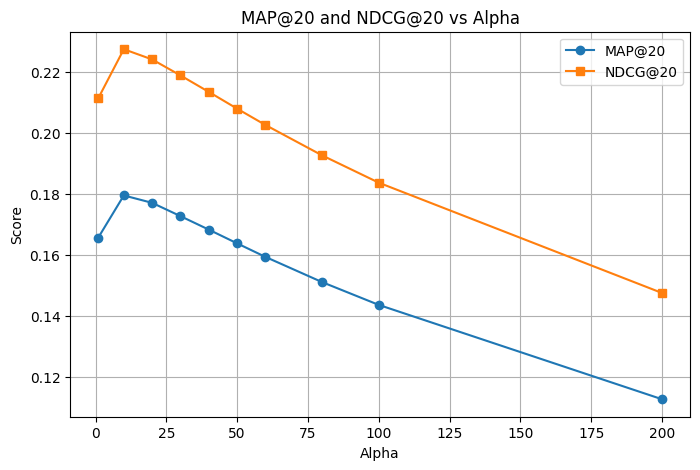

In [60]:
plt.figure(figsize=(8, 5))
plt.plot([c['alpha'] for c in alpha_combinations[:len(map_scores_alpha)]], map_scores_alpha, marker='o', label='MAP@20')
plt.plot([c['alpha'] for c in alpha_combinations[:len(map_scores_alpha)]], ndcg_scores_alpha, marker='s', label='NDCG@20')
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.title('MAP@20 and NDCG@20 vs Alpha')
plt.legend()
plt.grid(True)
plt.show()

In [67]:
alpha_params = {
    'factors': [600],
    'regularization': [1.0],
    'alpha': [5, 8, 10, 12, 14, 16, 18]
}

alpha_combinations = list(ParameterGrid(alpha_params))

In [68]:
alpha_combinations

[{'alpha': 5, 'factors': 600, 'regularization': 1.0},
 {'alpha': 8, 'factors': 600, 'regularization': 1.0},
 {'alpha': 10, 'factors': 600, 'regularization': 1.0},
 {'alpha': 12, 'factors': 600, 'regularization': 1.0},
 {'alpha': 14, 'factors': 600, 'regularization': 1.0},
 {'alpha': 16, 'factors': 600, 'regularization': 1.0},
 {'alpha': 18, 'factors': 600, 'regularization': 1.0}]

In [69]:
map_scores_alpha_2, ndcg_scores_alpha_2 = study_params(train_matrix_params, val_matrix_params, alpha_combinations, save_results=True, save_path='als_hyperparameter_tuning_results_alpha_bm25_fixed_2.csv')

100%|██████████| 7/7 [3:09:36<00:00, 1625.28s/it]  


In [71]:
print("MAP@20 scores for alpha 1, 10, 20, 30, 40, 50, 60, 80, 100 and 200:")
print(map_scores_alpha_2)
print("NDCG@20 scores for alpha 1, 10, 20, 30, 40, 50, 60, 80, 100 and 200:")
print(ndcg_scores_alpha_2)

MAP@20 scores for alpha 1, 10, 20, 30, 40, 50, 60, 80, 100 and 200:
[0.17795862339750562, 0.1792392928977428, 0.17947931962876276, 0.17937431366916393, 0.17899048325402123, 0.1785404156902338, 0.17780515022135773]
NDCG@20 scores for alpha 1, 10, 20, 30, 40, 50, 60, 80, 100 and 200:
[0.22623558971143465, 0.2273798867021636, 0.22740644256550346, 0.22710223455357947, 0.22651985491118082, 0.22585852965354164, 0.22496759986809178]


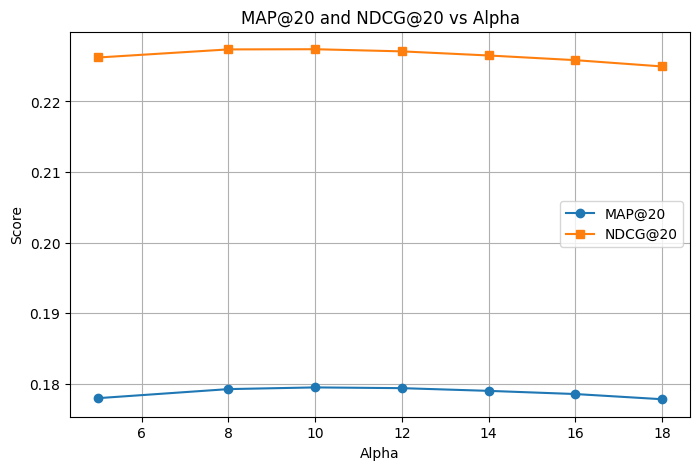

In [70]:
plt.figure(figsize=(8, 5))
plt.plot([c['alpha'] for c in alpha_combinations[:len(map_scores_alpha_2)]], map_scores_alpha_2, marker='o', label='MAP@20')
plt.plot([c['alpha'] for c in alpha_combinations[:len(map_scores_alpha_2)]], ndcg_scores_alpha_2, marker='s', label='NDCG@20')
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.title('MAP@20 and NDCG@20 vs Alpha')
plt.legend()
plt.grid(True)
plt.show()

In [75]:
final_factors_params = {
    'factors': [600],
    'regularization': [0.001, 0.01, 0.1, 1.0],
    'alpha': [9, 10, 11]
}

final_factors_combinations = list(ParameterGrid(final_factors_params))

In [76]:
final_factors_combinations

[{'alpha': 9, 'factors': 600, 'regularization': 0.001},
 {'alpha': 9, 'factors': 600, 'regularization': 0.01},
 {'alpha': 9, 'factors': 600, 'regularization': 0.1},
 {'alpha': 9, 'factors': 600, 'regularization': 1.0},
 {'alpha': 10, 'factors': 600, 'regularization': 0.001},
 {'alpha': 10, 'factors': 600, 'regularization': 0.01},
 {'alpha': 10, 'factors': 600, 'regularization': 0.1},
 {'alpha': 10, 'factors': 600, 'regularization': 1.0},
 {'alpha': 11, 'factors': 600, 'regularization': 0.001},
 {'alpha': 11, 'factors': 600, 'regularization': 0.01},
 {'alpha': 11, 'factors': 600, 'regularization': 0.1},
 {'alpha': 11, 'factors': 600, 'regularization': 1.0}]

In [77]:
map_scores_final, ndcg_scores_final = study_params(train_matrix_params, val_matrix_params, final_factors_combinations, save_results=True, save_path='als_hyperparameter_tuning_results_final_bm25_fixed.csv')

100%|██████████| 12/12 [4:43:26<00:00, 1417.25s/it] 


In [78]:
print(map_scores_final)
print(ndcg_scores_final)

[0.17550278311456566, 0.1766514219714136, 0.1788771399181561, 0.17946083618959086, 0.17543165679737013, 0.17663438014802585, 0.17890700233956194, 0.17947931962876276, 0.17550453204222627, 0.1766046697910109, 0.17880502945986, 0.1794655019138083]
[0.22472364365066005, 0.22552131296126016, 0.22698001121725608, 0.22748050153559726, 0.22464293751159947, 0.22545820437747924, 0.22694946873278635, 0.22740644256550346, 0.22465663426979957, 0.22540401500416082, 0.22676572480693094, 0.2272724130967589]


In [79]:
best_map_idx = max(range(len(map_scores_final)), key=lambda i: map_scores_final[i])
best_ndcg_idx = max(range(len(ndcg_scores_final)), key=lambda i: ndcg_scores_final[i])

best_map_params = final_factors_combinations[best_map_idx]
best_ndcg_params = final_factors_combinations[best_ndcg_idx]

print(f"Best MAP: index={best_map_idx}, params={best_map_params}, MAP={map_scores_final[best_map_idx]}")
print(f"Best NDCG: index={best_ndcg_idx}, params={best_ndcg_params}, NDCG={ndcg_scores_final[best_ndcg_idx]}")


Best MAP: index=7, params={'alpha': 10, 'factors': 600, 'regularization': 1.0}, MAP=0.17947931962876276
Best NDCG: index=3, params={'alpha': 9, 'factors': 600, 'regularization': 1.0}, NDCG=0.22748050153559726


In [83]:
print("Five best MAP@20 scores and their parameters:")
for idx in sorted(range(len(map_scores_final)), key=lambda i: map_scores_final[i], reverse=True)[0:5]:
    print(f"Index: {idx}, MAP@20: {map_scores_final[idx]:.6f}, Params: {final_factors_combinations[idx]}")
print("\nFive best NDCG@20 scores and their parameters:")
for idx in sorted(range(len(ndcg_scores_final)), key=lambda i: ndcg_scores_final[i], reverse=True)[0:5]:
    print(f"Index: {idx}, NDCG@20: {ndcg_scores_final[idx]:.6f}, Params: {final_factors_combinations[idx]}")

Five best MAP@20 scores and their parameters:
Index: 7, MAP@20: 0.179479, Params: {'alpha': 10, 'factors': 600, 'regularization': 1.0}
Index: 11, MAP@20: 0.179466, Params: {'alpha': 11, 'factors': 600, 'regularization': 1.0}
Index: 3, MAP@20: 0.179461, Params: {'alpha': 9, 'factors': 600, 'regularization': 1.0}
Index: 6, MAP@20: 0.178907, Params: {'alpha': 10, 'factors': 600, 'regularization': 0.1}
Index: 2, MAP@20: 0.178877, Params: {'alpha': 9, 'factors': 600, 'regularization': 0.1}

Five best NDCG@20 scores and their parameters:
Index: 3, NDCG@20: 0.227481, Params: {'alpha': 9, 'factors': 600, 'regularization': 1.0}
Index: 7, NDCG@20: 0.227406, Params: {'alpha': 10, 'factors': 600, 'regularization': 1.0}
Index: 11, NDCG@20: 0.227272, Params: {'alpha': 11, 'factors': 600, 'regularization': 1.0}
Index: 2, NDCG@20: 0.226980, Params: {'alpha': 9, 'factors': 600, 'regularization': 0.1}
Index: 6, NDCG@20: 0.226949, Params: {'alpha': 10, 'factors': 600, 'regularization': 0.1}


In [81]:
results_final_df = pd.DataFrame(final_factors_combinations)
results_final_df['MAP@20'] = map_scores_final
results_final_df['NDCG@20'] = ndcg_scores_final

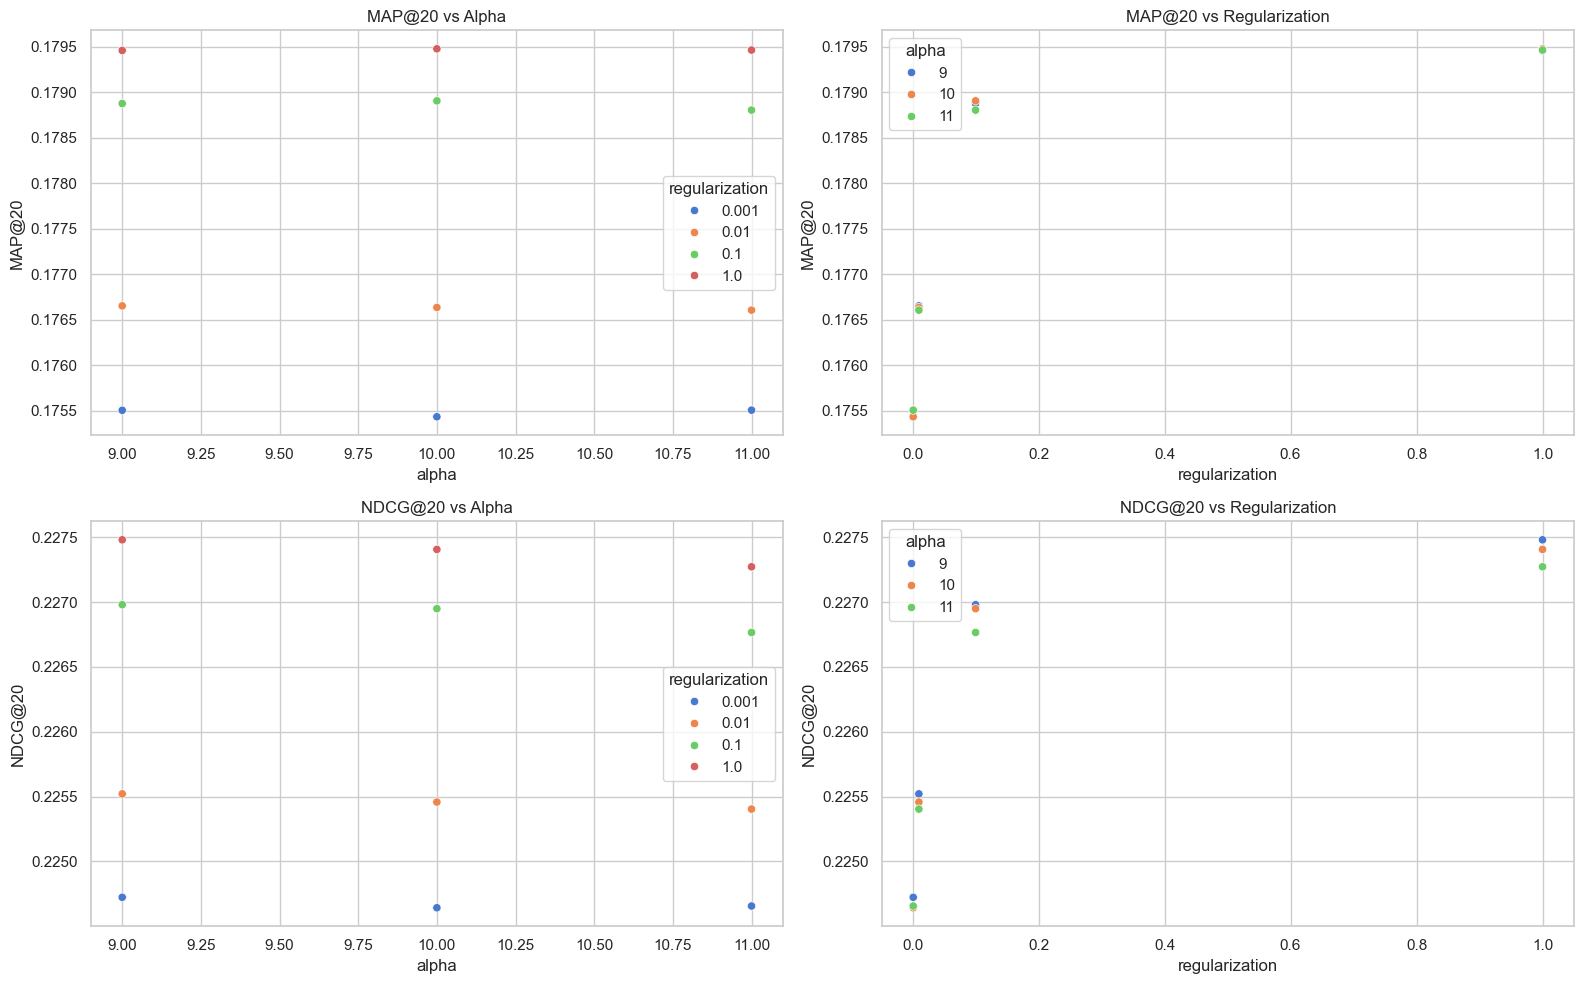

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Crear paletas adaptadas al número de categorías
palette_reg = sns.color_palette("muted", n_colors=results_final_df['regularization'].nunique())
palette_alpha = sns.color_palette("muted", n_colors=results_final_df['alpha'].nunique())

# MAP@20 plots
sns.scatterplot(data=results_final_df, x='alpha', y='MAP@20', hue='regularization', ax=axes[0, 0], palette=palette_reg)
axes[0, 0].set_title('MAP@20 vs Alpha')

sns.scatterplot(data=results_final_df, x='regularization', y='MAP@20', hue='alpha', ax=axes[0, 1], palette=palette_alpha)
axes[0, 1].set_title('MAP@20 vs Regularization')

# NDCG@20 plots
sns.scatterplot(data=results_final_df, x='alpha', y='NDCG@20', hue='regularization', ax=axes[1, 0], palette=palette_reg)
axes[1, 0].set_title('NDCG@20 vs Alpha')

sns.scatterplot(data=results_final_df, x='regularization', y='NDCG@20', hue='alpha', ax=axes[1, 1], palette=palette_alpha)
axes[1, 1].set_title('NDCG@20 vs Regularization')

plt.tight_layout()
plt.show()


Final hyperparameters:
- Latent factors: 600
- Alpha: 9
- Regularization: 1

In [18]:
best_als_model = AlternatingLeastSquares(
            factors=600,
            regularization=1,
            alpha=9,
            iterations=20,
            num_threads=1,
            random_state=RANDOM_STATE
        )
        
best_als_model.fit(interaction_matrix_user_item_bm25, show_progress=True)

100%|██████████| 20/20 [15:39<00:00, 47.00s/it]


In [19]:
import pickle

with open('models/als_model_600_9_1.pkl', 'wb') as f:
    pickle.dump(best_als_model, f)